In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH = '/kaggle/input/anerbc-1-gan-seg/AneRBC_I_combine/'

In [3]:
BUFFER_SIZE = 2
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

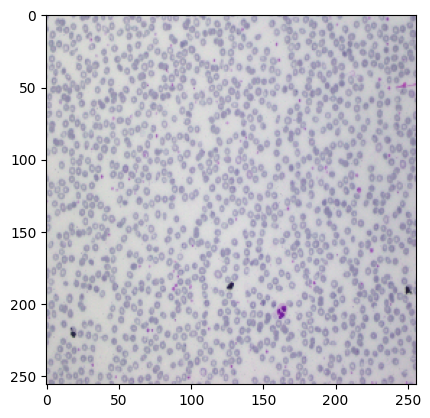

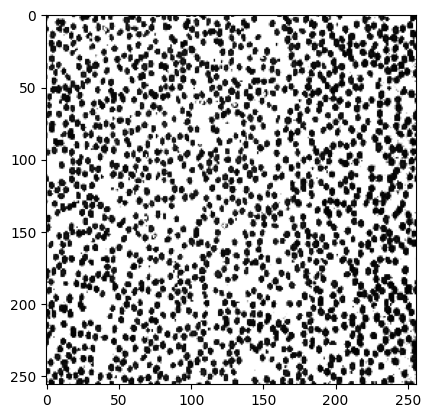

In [5]:
inp, re = load(PATH+'train/001_a.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [8]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

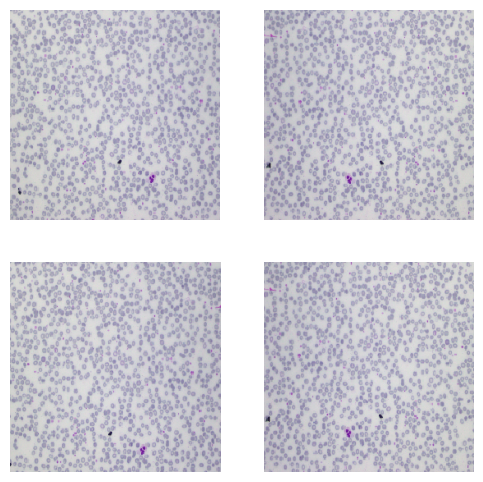

In [10]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [12]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [18]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [19]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [20]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

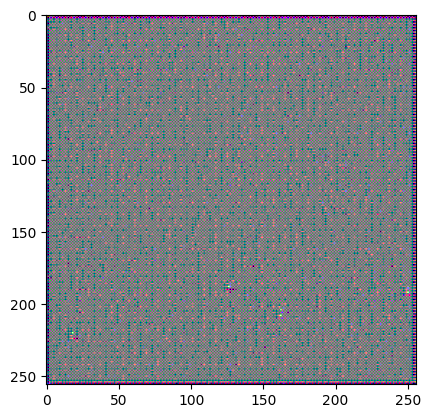

In [22]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [23]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [25]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

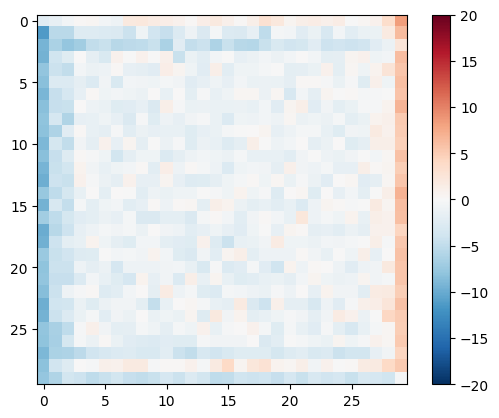

In [26]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [27]:
# ... [Your previous code remains unchanged up to the definition of the train_step function]
# Define the loss object
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define the discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Define additional metrics and loss functions
def dice_coef(y_true, y_pred):
    smooth = 1e-10
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

def precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + 1e-5)

def recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + 1e-5)

def specificity(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    possible_negatives = tf.reduce_sum(1 - y_true)
    return true_negatives / possible_negatives
def accuracy(y_true, y_pred):
    y_true = tf.round(tf.sigmoid(y_true))
    y_pred = tf.round(tf.sigmoid(y_pred))
    correct_pixels = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_pixels, tf.float32))
    return accuracy


# 2. Modify the Training Loop and 3. Store the Metrics
train_metrics = {
    'gen_total_loss': [],
    'gen_gan_loss': [],
    'gen_l1_loss': [],
    'disc_loss': [],
    'dice_coef': [],
    'iou': [],
    'precision': [],
    'recall': [],
    'specificity': []
}

val_metrics = {
    'val_gen_total_loss': [],
    'val_gen_gan_loss': [],
    'val_gen_l1_loss': [],
    'val_disc_loss': [],
    'val_dice_coef': [],
    'val_iou': [],
    'val_precision': [],
    'val_recall': [],
    'val_specificity': []
}

# 4. Modify the train_step Function
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # ... [rest of the train_step function remains unchanged]

    # Calculate metrics
    dice = dice_coef(target, gen_output)
    iou_val = iou(target, gen_output)
    prec = precision(target, gen_output)
    rec = recall(target, gen_output)
    spec = specificity(target, gen_output)

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice, iou_val, prec, rec, spec

# 5. Validation Loop
def validate_step(input_image, target):
    gen_output = generator(input_image, training=False)
    disc_real_output = discriminator([input_image, target], training=False)
    disc_generated_output = discriminator([input_image, gen_output], training=False)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate metrics
    dice = dice_coef(target, gen_output)
    iou_val = iou(target, gen_output)
    prec = precision(target, gen_output)
    rec = recall(target, gen_output)
    spec = specificity(target, gen_output)

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice, iou_val, prec, rec, spec

# Update the fit function to include validation and store metrics
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        # ... [rest of the fit function remains unchanged]

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice, iou_val, prec, rec, spec = train_step(input_image, target)
            # Store metrics
            train_metrics['gen_total_loss'].append(gen_total_loss)
            train_metrics['gen_gan_loss'].append(gen_gan_loss)
            train_metrics['gen_l1_loss'].append(gen_l1_loss)
            train_metrics['disc_loss'].append(disc_loss)
            train_metrics['dice_coef'].append(dice)
            train_metrics['iou'].append(iou_val)
            train_metrics['precision'].append(prec)
            train_metrics['recall'].append(rec)
            train_metrics['specificity'].append(spec)

        # Validate
        for n, (input_image, target) in test_ds.enumerate():
            val_gen_total_loss, val_gen_gan_loss, val_gen_l1_loss, val_disc_loss, val_dice, val_iou_val, val_prec, val_rec, val_spec = validate_step(input_image, target)
            # Store metrics
            val_metrics['val_gen_total_loss'].append(val_gen_total_loss)
            val_metrics['val_gen_gan_loss'].append(val_gen_gan_loss)
            val_metrics['val_gen_l1_loss'].append(val_gen_l1_loss)
            val_metrics['val_disc_loss'].append(val_disc_loss)
            val_metrics['val_dice_coef'].append(val_dice)
            val_metrics['val_iou'].append(val_iou_val)
            val_metrics['val_precision'].append(val_prec)
            val_metrics['val_recall'].append(val_rec)
            val_metrics['val_specificity'].append(val_spec)

# ... [rest of your code remains unchanged]


In [28]:
# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
# def discriminator_loss(disc_real_output, disc_generated_output):
#   real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#   generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#   total_disc_loss = real_loss + generated_loss

#   return total_disc_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
checkpoint_dir = '/kaggle/working/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
!mkdir 'results'
#indx = 0;
def generate_images(model, test_input, tar,indx=0):
  prediction = model(test_input, training=True)
  fig = plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  #print(tar)

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  fig.savefig('results/' + str(indx) + '.png')
# Initialize a list to store displayed images
# persistent_display_list = []

# def generate_images(model, test_input, tar, ep=0):
#   prediction = model(test_input, training=True)
#   plt.figure(figsize=(15, 15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   title = ['Input Image', 'Ground Truth', 'Predicted Image']

#   # Add the current display list to the persistent list
#   persistent_display_list.append(display_list)

#   if ep % 5 == 0:
#     # Display all images in the persistent display list
#     for display_list in persistent_display_list:
#       plt.figure(figsize=(15, 15))
#       for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(title[i])
#         # Getting the pixel values between [0, 1] to plot it.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')
#       plt.show()

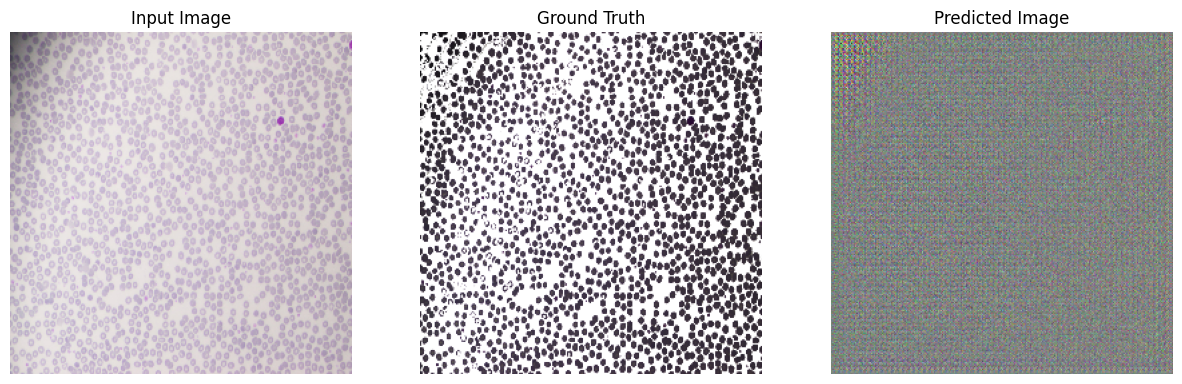

In [33]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [34]:
EPOCHS = 200

In [35]:
import datetime
log_dir=log_dir="/kaggle/working/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [36]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [37]:
import tensorflow as tf
import time
from IPython import display

@tf.function
def train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        dice_coef_value = dice_coef(target, gen_output)
        iou_value = iou(target, gen_output)
        precision_value = precision(target, gen_output)
        recall_value = recall(target, gen_output)
        specificity_value = specificity(target, gen_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value


In [38]:
@tf.function
def test_step(input_image, target, generator, discriminator, loss_object, accuracy):
    gen_output = generator(input_image, training=False)
    disc_generated_output = discriminator([input_image, gen_output], training=False)
    
    val_loss = loss_object(target, gen_output)
    val_accuracy = accuracy(target, gen_output)
    val_dice_coef = dice_coef(target, gen_output)
    val_iou = iou(target, gen_output)
    val_precision = precision(target, gen_output)
    val_recall = recall(target, gen_output)
    val_specificity = specificity(target, gen_output)

    return val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity


In [39]:
# def fit(train_ds, epochs, test_ds, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object, accuracy, generate_images, checkpoint, checkpoint_prefix):
#     for epoch in range(epochs):
#         start = time.time()

#         display.clear_output(wait=True)

#         for example_input, example_target in test_ds.take(1):
#             generate_images(generator, example_input, example_target)
#         print("Epoch: ", epoch)

#         for n, (input_image, target) in train_ds.enumerate():
#             gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value = train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)
#             print(f"Training - Loss: {gen_total_loss:.4f}, GAN Loss: {gen_gan_loss:.4f}, L1 Loss: {gen_l1_loss:.4f}, Dice Coef: {dice_coef_value:.4f}, IOU: {iou_value:.4f}, Precision: {precision_value:.4f}, Recall: {recall_value:.4f}, Specificity: {specificity_value:.4f}")

#         for input_image, target in test_ds:
#             val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity = test_step(input_image, target, generator, discriminator, loss_object, accuracy)
        
#         print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Dice Coef: {val_dice_coef:.4f}, IOU: {val_iou:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, Specificity: {val_specificity:.4f}")

#         if (epoch + 1) % 100 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

#         print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
#     checkpoint.save(file_prefix = checkpoint_prefix)

# def fit(train_ds, epochs, test_ds, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object, accuracy, generate_images, checkpoint, checkpoint_prefix):
#     for epoch in range(epochs):
#         start = time.time()

#         # Initialize accumulators
#         total_gen_loss, total_gen_gan_loss, total_gen_l1_loss, total_disc_loss = 0, 0, 0, 0
#         total_dice_coef, total_iou, total_precision, total_recall, total_specificity = 0, 0, 0, 0, 0
#         num_batches = 0

#         display.clear_output(wait=True)

#         for example_input, example_target in test_ds.take(1):
#             generate_images(generator, example_input, example_target)
#         print("Epoch: ", epoch)

#         for n, (input_image, target) in train_ds.enumerate():
#             gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value = train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            
#             # Update accumulators
#             total_gen_loss += gen_total_loss
#             total_gen_gan_loss += gen_gan_loss
#             total_gen_l1_loss += gen_l1_loss
#             total_disc_loss += disc_loss
#             total_dice_coef += dice_coef_value
#             total_iou += iou_value
#             total_precision += precision_value
#             total_recall += recall_value
#             total_specificity += specificity_value
#             num_batches += 1

#         # Print average values for training
#         print(f"Training - Avg Loss: {total_gen_loss/num_batches:.4f}, Avg GAN Loss: {total_gen_gan_loss/num_batches:.4f}, Avg L1 Loss: {total_gen_l1_loss/num_batches:.4f}, Avg Dice Coef: {total_dice_coef/num_batches:.4f}, Avg IOU: {total_iou/num_batches:.4f}, Avg Precision: {total_precision/num_batches:.4f}, Avg Recall: {total_recall/num_batches:.4f}, Avg Specificity: {total_specificity/num_batches:.4f}")

#         # Reset accumulators for validation
#         total_val_loss, total_val_accuracy, total_val_dice_coef, total_val_iou, total_val_precision, total_val_recall, total_val_specificity = 0, 0, 0, 0, 0, 0, 0
#         num_val_batches = 0

#         for input_image, target in test_ds:
#             val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity = test_step(input_image, target, generator, discriminator, loss_object, accuracy)
            
#             # Update accumulators for validation
#             total_val_loss += val_loss
#             total_val_accuracy += val_accuracy
#             total_val_dice_coef += val_dice_coef
#             total_val_iou += val_iou
#             total_val_precision += val_precision
#             total_val_recall += val_recall
#             total_val_specificity += val_specificity
#             num_val_batches += 1

#         # Print average values for validation
#         print(f"Validation - Avg Loss: {total_val_loss/num_val_batches:.4f}, Avg Accuracy: {total_val_accuracy/num_val_batches:.4f}, Avg Dice Coef: {total_val_dice_coef/num_val_batches:.4f}, Avg IOU: {total_val_iou/num_val_batches:.4f}, Avg Precision: {total_val_precision/num_val_batches:.4f}, Avg Recall: {total_val_recall/num_val_batches:.4f}, Avg Specificity: {total_val_specificity/num_val_batches:.4f}")

#         if (epoch + 1) % 100 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

#         print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
#     checkpoint.save(file_prefix = checkpoint_prefix)


In [40]:
def fit(train_ds, epochs, test_ds, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object, accuracy, checkpoint, checkpoint_prefix):
    for epoch in range(epochs):
        start = time.time()

        # Initialize accumulators
        total_gen_loss, total_gen_gan_loss, total_gen_l1_loss, total_disc_loss = 0, 0, 0, 0
        total_dice_coef, total_iou, total_precision, total_recall, total_specificity = 0, 0, 0, 0, 0
        num_batches = 0

        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value = train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            
            # Update accumulators
            total_gen_loss += gen_total_loss
            total_gen_gan_loss += gen_gan_loss
            total_gen_l1_loss += gen_l1_loss
            total_disc_loss += disc_loss
            total_dice_coef += dice_coef_value
            total_iou += iou_value
            total_precision += precision_value
            total_recall += recall_value
            total_specificity += specificity_value
            num_batches += 1

        # Print average values for training
        print(f"Training - Avg Loss: {total_gen_loss/num_batches:.4f}, Avg GAN Loss: {total_gen_gan_loss/num_batches:.4f}, Avg L1 Loss: {total_gen_l1_loss/num_batches:.4f}, Avg Dice Coef: {total_dice_coef/num_batches:.4f}, Avg IOU: {total_iou/num_batches:.4f}, Avg Precision: {total_precision/num_batches:.4f}, Avg Recall: {total_recall/num_batches:.4f}, Avg Specificity: {total_specificity/num_batches:.4f}")

        # Reset accumulators for validation
        total_val_loss, total_val_accuracy, total_val_dice_coef, total_val_iou, total_val_precision, total_val_recall, total_val_specificity = 0, 0, 0, 0, 0, 0, 0
        num_val_batches = 0

        for input_image, target in test_ds:
            val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity = test_step(input_image, target, generator, discriminator, loss_object, accuracy)
            
            # Update accumulators for validation
            total_val_loss += val_loss
            total_val_accuracy += val_accuracy
            total_val_dice_coef += val_dice_coef
            total_val_iou += val_iou
            total_val_precision += val_precision
            total_val_recall += val_recall
            total_val_specificity += val_specificity
            num_val_batches += 1

        # Print average values for validation
        print(f"Validation - Avg Loss: {total_val_loss/num_val_batches:.4f}, Avg Accuracy: {total_val_accuracy/num_val_batches:.4f}, Avg Dice Coef: {total_val_dice_coef/num_val_batches:.4f}, Avg IOU: {total_val_iou/num_val_batches:.4f}, Avg Precision: {total_val_precision/num_val_batches:.4f}, Avg Recall: {total_val_recall/num_val_batches:.4f}, Avg Specificity: {total_val_specificity/num_val_batches:.4f}")

        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

    checkpoint.save(file_prefix = checkpoint_prefix)

history = fit(
    train_dataset, 
    EPOCHS, 
    test_dataset, 
    generator, 
    discriminator, 
    generator_optimizer, 
    discriminator_optimizer, 
    loss_object, 
    accuracy,  
    checkpoint, 
    checkpoint_prefix
)


Epoch:  0


2023-11-01 07:11:43.521382: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 30.4965, Avg GAN Loss: 1.8388, Avg L1 Loss: 0.2866, Avg Dice Coef: 1.2789, Avg IOU: 2.1658, Avg Precision: 1.3038, Avg Recall: 1.3266, Avg Specificity: 1.2444
Validation - Avg Loss: 0.7487, Avg Accuracy: 0.6547, Avg Dice Coef: 0.6835, Avg IOU: 0.5218, Avg Precision: 0.5081, Avg Recall: 1.0536, Avg Specificity: 0.2456
Time taken for epoch 1 is 33.69979381561279 sec

Epoch:  1


2023-11-01 07:12:13.776291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 17.8126, Avg GAN Loss: 1.9637, Avg L1 Loss: 0.1585, Avg Dice Coef: 1.5754, Avg IOU: 4.3632, Avg Precision: 1.5623, Avg Recall: 1.6135, Avg Specificity: 1.4222
Validation - Avg Loss: 0.6983, Avg Accuracy: 0.6747, Avg Dice Coef: 0.7771, Avg IOU: 0.6386, Avg Precision: 0.5825, Avg Recall: 1.1725, Avg Specificity: 0.3801
Time taken for epoch 2 is 21.728800296783447 sec

Epoch:  2


2023-11-01 07:12:35.668202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 15.5239, Avg GAN Loss: 1.7287, Avg L1 Loss: 0.1380, Avg Dice Coef: 1.6271, Avg IOU: 5.3447, Avg Precision: 1.6276, Avg Recall: 1.6518, Avg Specificity: 1.4590
Validation - Avg Loss: 0.3789, Avg Accuracy: 0.9155, Avg Dice Coef: 1.5000, Avg IOU: 3.2515, Avg Precision: 1.4589, Avg Recall: 1.5517, Avg Specificity: 1.3525
Time taken for epoch 3 is 21.918137788772583 sec

Epoch:  3


2023-11-01 07:12:57.430957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 14.0710, Avg GAN Loss: 1.3642, Avg L1 Loss: 0.1271, Avg Dice Coef: 1.6501, Avg IOU: 2.5783, Avg Precision: 1.6620, Avg Recall: 1.6572, Avg Specificity: 1.4759
Validation - Avg Loss: 0.3967, Avg Accuracy: 0.9006, Avg Dice Coef: 1.4101, Avg IOU: 2.4412, Avg Precision: 1.2936, Avg Recall: 1.5549, Avg Specificity: 1.2571
Time taken for epoch 4 is 21.759220600128174 sec

Epoch:  4


2023-11-01 07:13:19.131052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 12.8772, Avg GAN Loss: 1.0793, Avg L1 Loss: 0.1180, Avg Dice Coef: 1.6635, Avg IOU: 7.9652, Avg Precision: 1.6767, Avg Recall: 1.7060, Avg Specificity: 1.4846
Validation - Avg Loss: 0.3294, Avg Accuracy: 0.9378, Avg Dice Coef: 1.7352, Avg IOU: 8.9806, Avg Precision: 1.8830, Avg Recall: 1.6134, Avg Specificity: 1.5512
Time taken for epoch 5 is 21.701289892196655 sec

Epoch:  5


2023-11-01 07:13:40.836179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 12.1237, Avg GAN Loss: 0.9337, Avg L1 Loss: 0.1119, Avg Dice Coef: 1.6639, Avg IOU: -1.5571, Avg Precision: 1.6778, Avg Recall: 1.6670, Avg Specificity: 1.4838
Validation - Avg Loss: 0.3780, Avg Accuracy: 0.9239, Avg Dice Coef: 1.4322, Avg IOU: 2.6187, Avg Precision: 1.3166, Avg Recall: 1.5752, Avg Specificity: 1.2743
Time taken for epoch 6 is 21.68628239631653 sec

Epoch:  6


2023-11-01 07:14:02.575717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 11.6911, Avg GAN Loss: 0.9260, Avg L1 Loss: 0.1077, Avg Dice Coef: 1.6740, Avg IOU: 18.2968, Avg Precision: 1.6872, Avg Recall: 1.6919, Avg Specificity: 1.4871
Validation - Avg Loss: 0.3353, Avg Accuracy: 0.9370, Avg Dice Coef: 1.6906, Avg IOU: 6.4130, Avg Precision: 1.7256, Avg Recall: 1.6609, Avg Specificity: 1.5083
Time taken for epoch 7 is 21.767881393432617 sec

Epoch:  7


2023-11-01 07:14:24.320369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 11.2484, Avg GAN Loss: 0.9371, Avg L1 Loss: 0.1031, Avg Dice Coef: 1.6782, Avg IOU: 13.8685, Avg Precision: 1.6963, Avg Recall: 1.6808, Avg Specificity: 1.4917
Validation - Avg Loss: 0.3829, Avg Accuracy: 0.9171, Avg Dice Coef: 1.4263, Avg IOU: 2.6854, Avg Precision: 1.3180, Avg Recall: 1.5644, Avg Specificity: 1.2696
Time taken for epoch 8 is 21.71713876724243 sec

Epoch:  8


2023-11-01 07:14:46.035498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 11.0039, Avg GAN Loss: 0.9410, Avg L1 Loss: 0.1006, Avg Dice Coef: 1.6826, Avg IOU: 9.4214, Avg Precision: 1.6967, Avg Recall: 1.6883, Avg Specificity: 1.4908
Validation - Avg Loss: 0.3367, Avg Accuracy: 0.9447, Avg Dice Coef: 1.6344, Avg IOU: 5.1944, Avg Precision: 1.6500, Avg Recall: 1.6232, Avg Specificity: 1.4643
Time taken for epoch 9 is 21.739777326583862 sec

Epoch:  9


2023-11-01 07:15:07.827273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 10.8193, Avg GAN Loss: 0.9384, Avg L1 Loss: 0.0988, Avg Dice Coef: 1.6842, Avg IOU: 1.8001, Avg Precision: 1.6985, Avg Recall: 1.6991, Avg Specificity: 1.4961
Validation - Avg Loss: 0.3308, Avg Accuracy: 0.9409, Avg Dice Coef: 1.7189, Avg IOU: 7.6837, Avg Precision: 1.7635, Avg Recall: 1.6803, Avg Specificity: 1.5298
Time taken for epoch 10 is 21.79576015472412 sec

Epoch:  10


2023-11-01 07:15:29.601067: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 10.5316, Avg GAN Loss: 0.9353, Avg L1 Loss: 0.0960, Avg Dice Coef: 1.6887, Avg IOU: 8.0352, Avg Precision: 1.7087, Avg Recall: 1.6948, Avg Specificity: 1.4981
Validation - Avg Loss: 0.3612, Avg Accuracy: 0.9289, Avg Dice Coef: 1.5395, Avg IOU: 3.6725, Avg Precision: 1.4732, Avg Recall: 1.6182, Avg Specificity: 1.3774
Time taken for epoch 11 is 21.744537115097046 sec

Epoch:  11


2023-11-01 07:15:51.281262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 10.4637, Avg GAN Loss: 0.9259, Avg L1 Loss: 0.0954, Avg Dice Coef: 1.6924, Avg IOU: 14.6184, Avg Precision: 1.7124, Avg Recall: 1.7027, Avg Specificity: 1.4983
Validation - Avg Loss: 0.3654, Avg Accuracy: 0.9226, Avg Dice Coef: 1.5604, Avg IOU: 4.0352, Avg Precision: 1.4919, Avg Recall: 1.6418, Avg Specificity: 1.3907
Time taken for epoch 12 is 21.676223278045654 sec

Epoch:  12


2023-11-01 07:16:13.258044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 10.2455, Avg GAN Loss: 0.9320, Avg L1 Loss: 0.0931, Avg Dice Coef: 1.6958, Avg IOU: 9.0623, Avg Precision: 1.7173, Avg Recall: 1.7019, Avg Specificity: 1.5000
Validation - Avg Loss: 0.3712, Avg Accuracy: 0.9348, Avg Dice Coef: 1.4161, Avg IOU: 2.5384, Avg Precision: 1.3001, Avg Recall: 1.5603, Avg Specificity: 1.2599
Time taken for epoch 13 is 21.983168363571167 sec

Epoch:  13


2023-11-01 07:16:34.953448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 10.1446, Avg GAN Loss: 0.9280, Avg L1 Loss: 0.0922, Avg Dice Coef: 1.6951, Avg IOU: 28.3818, Avg Precision: 1.7132, Avg Recall: 1.7157, Avg Specificity: 1.4978
Validation - Avg Loss: 0.3394, Avg Accuracy: 0.9458, Avg Dice Coef: 1.6255, Avg IOU: 5.0133, Avg Precision: 1.6160, Avg Recall: 1.6403, Avg Specificity: 1.4541
Time taken for epoch 14 is 21.712917804718018 sec

Epoch:  14


2023-11-01 07:16:56.724534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.9026, Avg GAN Loss: 0.9316, Avg L1 Loss: 0.0897, Avg Dice Coef: 1.6978, Avg IOU: 641.5678, Avg Precision: 1.7226, Avg Recall: 1.6914, Avg Specificity: 1.4983
Validation - Avg Loss: 0.3384, Avg Accuracy: 0.9332, Avg Dice Coef: 1.6666, Avg IOU: 6.4590, Avg Precision: 1.8056, Avg Recall: 1.5516, Avg Specificity: 1.5023
Time taken for epoch 15 is 21.754083156585693 sec

Epoch:  15


2023-11-01 07:17:18.407343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.7786, Avg GAN Loss: 0.9063, Avg L1 Loss: 0.0887, Avg Dice Coef: 1.6991, Avg IOU: 9.1711, Avg Precision: 1.7194, Avg Recall: 1.7290, Avg Specificity: 1.4986
Validation - Avg Loss: 0.3457, Avg Accuracy: 0.9441, Avg Dice Coef: 1.5595, Avg IOU: 4.1929, Avg Precision: 1.5067, Avg Recall: 1.6193, Avg Specificity: 1.3952
Time taken for epoch 16 is 21.687286615371704 sec

Epoch:  16


2023-11-01 07:17:40.095198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.6041, Avg GAN Loss: 0.9121, Avg L1 Loss: 0.0869, Avg Dice Coef: 1.6986, Avg IOU: 9.4149, Avg Precision: 1.7218, Avg Recall: 1.6955, Avg Specificity: 1.4991
Validation - Avg Loss: 0.3494, Avg Accuracy: 0.9420, Avg Dice Coef: 1.5256, Avg IOU: 3.4923, Avg Precision: 1.4755, Avg Recall: 1.5822, Avg Specificity: 1.3695
Time taken for epoch 17 is 21.69779086112976 sec

Epoch:  17


2023-11-01 07:18:01.813975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.5633, Avg GAN Loss: 0.9262, Avg L1 Loss: 0.0864, Avg Dice Coef: 1.6967, Avg IOU: 14.4762, Avg Precision: 1.7147, Avg Recall: 1.6968, Avg Specificity: 1.4938
Validation - Avg Loss: 0.3135, Avg Accuracy: 0.9479, Avg Dice Coef: 1.8519, Avg IOU: 14.0677, Avg Precision: 2.0365, Avg Recall: 1.7019, Avg Specificity: 1.6274
Time taken for epoch 18 is 21.75226402282715 sec

Epoch:  18


2023-11-01 07:18:23.571588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.4594, Avg GAN Loss: 0.9190, Avg L1 Loss: 0.0854, Avg Dice Coef: 1.7071, Avg IOU: -5.5238, Avg Precision: 1.7288, Avg Recall: 1.7051, Avg Specificity: 1.4991
Validation - Avg Loss: 0.3495, Avg Accuracy: 0.9321, Avg Dice Coef: 1.5638, Avg IOU: 4.3544, Avg Precision: 1.6071, Avg Recall: 1.5346, Avg Specificity: 1.4157
Time taken for epoch 19 is 21.739221334457397 sec

Epoch:  19


2023-11-01 07:18:45.375467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.3940, Avg GAN Loss: 0.9446, Avg L1 Loss: 0.0845, Avg Dice Coef: 1.6987, Avg IOU: 2.0967, Avg Precision: 1.7197, Avg Recall: 1.6957, Avg Specificity: 1.4970
Validation - Avg Loss: 0.3307, Avg Accuracy: 0.9456, Avg Dice Coef: 1.7164, Avg IOU: 6.0719, Avg Precision: 1.7620, Avg Recall: 1.6778, Avg Specificity: 1.5270
Time taken for epoch 20 is 21.803260326385498 sec

Epoch:  20


2023-11-01 07:19:07.095030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.3527, Avg GAN Loss: 0.9559, Avg L1 Loss: 0.0840, Avg Dice Coef: 1.6975, Avg IOU: 2.0493, Avg Precision: 1.7137, Avg Recall: 1.7396, Avg Specificity: 1.4928
Validation - Avg Loss: 0.3309, Avg Accuracy: 0.9455, Avg Dice Coef: 1.7041, Avg IOU: 7.1455, Avg Precision: 1.7346, Avg Recall: 1.6802, Avg Specificity: 1.5162
Time taken for epoch 21 is 21.704726696014404 sec

Epoch:  21


2023-11-01 07:19:28.839576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.3442, Avg GAN Loss: 1.0137, Avg L1 Loss: 0.0833, Avg Dice Coef: 1.6953, Avg IOU: -1.6492, Avg Precision: 1.7080, Avg Recall: 1.7017, Avg Specificity: 1.4926
Validation - Avg Loss: 0.3119, Avg Accuracy: 0.9458, Avg Dice Coef: 1.8777, Avg IOU: -28.4870, Avg Precision: 2.0909, Avg Recall: 1.7096, Avg Specificity: 1.6443
Time taken for epoch 22 is 21.804909706115723 sec

Epoch:  22


2023-11-01 07:19:50.635673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.2868, Avg GAN Loss: 1.0523, Avg L1 Loss: 0.0823, Avg Dice Coef: 1.6905, Avg IOU: 2.1541, Avg Precision: 1.7064, Avg Recall: 1.6922, Avg Specificity: 1.4934
Validation - Avg Loss: 0.3249, Avg Accuracy: 0.9453, Avg Dice Coef: 1.7923, Avg IOU: -149.5331, Avg Precision: 1.8880, Avg Recall: 1.7107, Avg Specificity: 1.5806
Time taken for epoch 23 is 21.74378275871277 sec

Epoch:  23


2023-11-01 07:20:12.750034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.3501, Avg GAN Loss: 1.0864, Avg L1 Loss: 0.0826, Avg Dice Coef: 1.6938, Avg IOU: 6.6680, Avg Precision: 1.7031, Avg Recall: 1.7069, Avg Specificity: 1.4892
Validation - Avg Loss: 0.3271, Avg Accuracy: 0.9427, Avg Dice Coef: 1.7575, Avg IOU: 8.6901, Avg Precision: 1.8432, Avg Recall: 1.6844, Avg Specificity: 1.5596
Time taken for epoch 24 is 22.14366888999939 sec

Epoch:  24


2023-11-01 07:20:34.552428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.2582, Avg GAN Loss: 1.0968, Avg L1 Loss: 0.0816, Avg Dice Coef: 1.6869, Avg IOU: 7.6113, Avg Precision: 1.7014, Avg Recall: 1.7007, Avg Specificity: 1.4891
Validation - Avg Loss: 0.3235, Avg Accuracy: 0.9469, Avg Dice Coef: 1.7625, Avg IOU: 19.8935, Avg Precision: 1.8484, Avg Recall: 1.6877, Avg Specificity: 1.5626
Time taken for epoch 25 is 21.793242692947388 sec

Epoch:  25


2023-11-01 07:20:56.274844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.2139, Avg GAN Loss: 1.0602, Avg L1 Loss: 0.0815, Avg Dice Coef: 1.6923, Avg IOU: 7.4583, Avg Precision: 1.7020, Avg Recall: 1.7013, Avg Specificity: 1.4883
Validation - Avg Loss: 0.3310, Avg Accuracy: 0.9452, Avg Dice Coef: 1.6378, Avg IOU: 2.4754, Avg Precision: 1.6701, Avg Recall: 1.6115, Avg Specificity: 1.4707
Time taken for epoch 26 is 21.682010412216187 sec

Epoch:  26


2023-11-01 07:21:17.962025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.2056, Avg GAN Loss: 1.0550, Avg L1 Loss: 0.0815, Avg Dice Coef: 1.6840, Avg IOU: -3.2340, Avg Precision: 1.6910, Avg Recall: 1.6933, Avg Specificity: 1.4828
Validation - Avg Loss: 0.3327, Avg Accuracy: 0.9391, Avg Dice Coef: 1.7589, Avg IOU: 12.1299, Avg Precision: 1.8288, Avg Recall: 1.6992, Avg Specificity: 1.5551
Time taken for epoch 27 is 21.694438934326172 sec

Epoch:  27


2023-11-01 07:21:39.670218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.1785, Avg GAN Loss: 1.0472, Avg L1 Loss: 0.0813, Avg Dice Coef: 1.6858, Avg IOU: -0.6341, Avg Precision: 1.6953, Avg Recall: 1.6955, Avg Specificity: 1.4866
Validation - Avg Loss: 0.3674, Avg Accuracy: 0.9250, Avg Dice Coef: 1.5006, Avg IOU: 3.2554, Avg Precision: 1.4282, Avg Recall: 1.5933, Avg Specificity: 1.3441
Time taken for epoch 28 is 21.699808835983276 sec

Epoch:  28


2023-11-01 07:22:01.390385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.1289, Avg GAN Loss: 1.0496, Avg L1 Loss: 0.0808, Avg Dice Coef: 1.6824, Avg IOU: 12.9461, Avg Precision: 1.6860, Avg Recall: 1.6975, Avg Specificity: 1.4821
Validation - Avg Loss: 0.3317, Avg Accuracy: 0.9437, Avg Dice Coef: 1.7204, Avg IOU: 7.3436, Avg Precision: 1.7625, Avg Recall: 1.6844, Avg Specificity: 1.5265
Time taken for epoch 29 is 21.734257221221924 sec

Epoch:  29


2023-11-01 07:22:23.131116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.1076, Avg GAN Loss: 1.0525, Avg L1 Loss: 0.0806, Avg Dice Coef: 1.6924, Avg IOU: 18.8983, Avg Precision: 1.7024, Avg Recall: 1.6977, Avg Specificity: 1.4846
Validation - Avg Loss: 0.3413, Avg Accuracy: 0.9451, Avg Dice Coef: 1.6117, Avg IOU: 4.5952, Avg Precision: 1.5819, Avg Recall: 1.6458, Avg Specificity: 1.4405
Time taken for epoch 30 is 21.731274127960205 sec

Epoch:  30


2023-11-01 07:22:44.840331: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.0723, Avg GAN Loss: 1.0620, Avg L1 Loss: 0.0801, Avg Dice Coef: 1.6905, Avg IOU: -1.4906, Avg Precision: 1.6963, Avg Recall: 1.7021, Avg Specificity: 1.4830
Validation - Avg Loss: 0.3228, Avg Accuracy: 0.9476, Avg Dice Coef: 1.7570, Avg IOU: 17.7611, Avg Precision: 1.8401, Avg Recall: 1.6860, Avg Specificity: 1.5600
Time taken for epoch 31 is 21.712758779525757 sec

Epoch:  31


2023-11-01 07:23:06.565318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 9.0576, Avg GAN Loss: 1.0575, Avg L1 Loss: 0.0800, Avg Dice Coef: 1.6932, Avg IOU: -265.4114, Avg Precision: 1.7011, Avg Recall: 1.7052, Avg Specificity: 1.4853
Validation - Avg Loss: 0.3372, Avg Accuracy: 0.9425, Avg Dice Coef: 1.7231, Avg IOU: -200.8020, Avg Precision: 1.7555, Avg Recall: 1.6965, Avg Specificity: 1.5247
Time taken for epoch 32 is 21.820827960968018 sec

Epoch:  32


2023-11-01 07:23:28.456707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.9784, Avg GAN Loss: 1.0577, Avg L1 Loss: 0.0792, Avg Dice Coef: 1.6890, Avg IOU: 9.7454, Avg Precision: 1.6944, Avg Recall: 1.7028, Avg Specificity: 1.4871
Validation - Avg Loss: 0.3360, Avg Accuracy: 0.9455, Avg Dice Coef: 1.6428, Avg IOU: 7.3400, Avg Precision: 1.6366, Avg Recall: 1.6525, Avg Specificity: 1.4687
Time taken for epoch 33 is 21.850448846817017 sec

Epoch:  33


2023-11-01 07:23:50.259178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.9810, Avg GAN Loss: 1.0576, Avg L1 Loss: 0.0792, Avg Dice Coef: 1.6858, Avg IOU: 6.8031, Avg Precision: 1.6941, Avg Recall: 1.6947, Avg Specificity: 1.4813
Validation - Avg Loss: 0.3294, Avg Accuracy: 0.9472, Avg Dice Coef: 1.7197, Avg IOU: 15.0371, Avg Precision: 1.7665, Avg Recall: 1.6800, Avg Specificity: 1.5311
Time taken for epoch 34 is 21.779075145721436 sec

Epoch:  34


2023-11-01 07:24:12.021438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.9456, Avg GAN Loss: 1.0836, Avg L1 Loss: 0.0786, Avg Dice Coef: 1.6928, Avg IOU: 3.5098, Avg Precision: 1.7007, Avg Recall: 1.7016, Avg Specificity: 1.4842
Validation - Avg Loss: 0.3431, Avg Accuracy: 0.9468, Avg Dice Coef: 1.5744, Avg IOU: 3.9260, Avg Precision: 1.5246, Avg Recall: 1.6306, Avg Specificity: 1.4098
Time taken for epoch 35 is 21.79659390449524 sec

Epoch:  35


2023-11-01 07:24:33.845443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.9449, Avg GAN Loss: 1.0914, Avg L1 Loss: 0.0785, Avg Dice Coef: 1.6931, Avg IOU: 21.0214, Avg Precision: 1.6978, Avg Recall: 1.8065, Avg Specificity: 1.4840
Validation - Avg Loss: 0.3510, Avg Accuracy: 0.9360, Avg Dice Coef: 1.5709, Avg IOU: 4.0739, Avg Precision: 1.5251, Avg Recall: 1.6282, Avg Specificity: 1.4075
Time taken for epoch 36 is 21.80143117904663 sec

Epoch:  36


2023-11-01 07:24:56.115152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.9401, Avg GAN Loss: 1.1035, Avg L1 Loss: 0.0784, Avg Dice Coef: 1.6875, Avg IOU: 11.2920, Avg Precision: 1.6964, Avg Recall: 1.6985, Avg Specificity: 1.4843
Validation - Avg Loss: 0.3374, Avg Accuracy: 0.9449, Avg Dice Coef: 1.6188, Avg IOU: 5.4432, Avg Precision: 1.6032, Avg Recall: 1.6401, Avg Specificity: 1.4473
Time taken for epoch 37 is 22.257176399230957 sec

Epoch:  37


2023-11-01 07:25:17.843744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.9152, Avg GAN Loss: 1.0842, Avg L1 Loss: 0.0783, Avg Dice Coef: 1.6914, Avg IOU: 7.5173, Avg Precision: 1.6962, Avg Recall: 1.7068, Avg Specificity: 1.4822
Validation - Avg Loss: 0.3401, Avg Accuracy: 0.9415, Avg Dice Coef: 1.6742, Avg IOU: 5.7831, Avg Precision: 1.6768, Avg Recall: 1.6757, Avg Specificity: 1.4907
Time taken for epoch 38 is 21.82734203338623 sec

Epoch:  38


2023-11-01 07:25:39.712650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8950, Avg GAN Loss: 1.0929, Avg L1 Loss: 0.0780, Avg Dice Coef: 1.6887, Avg IOU: 4.4478, Avg Precision: 1.6959, Avg Recall: 1.7020, Avg Specificity: 1.4859
Validation - Avg Loss: 0.3340, Avg Accuracy: 0.9473, Avg Dice Coef: 1.6406, Avg IOU: 5.1201, Avg Precision: 1.6423, Avg Recall: 1.6421, Avg Specificity: 1.4670
Time taken for epoch 39 is 21.74304485321045 sec

Epoch:  39


2023-11-01 07:26:01.426492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8776, Avg GAN Loss: 1.0929, Avg L1 Loss: 0.0778, Avg Dice Coef: 1.6901, Avg IOU: 6.7324, Avg Precision: 1.6943, Avg Recall: 1.7027, Avg Specificity: 1.4843
Validation - Avg Loss: 0.3485, Avg Accuracy: 0.9430, Avg Dice Coef: 1.5954, Avg IOU: 4.2108, Avg Precision: 1.5433, Avg Recall: 1.6545, Avg Specificity: 1.4238
Time taken for epoch 40 is 21.705476999282837 sec

Epoch:  40


2023-11-01 07:26:23.153702: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8522, Avg GAN Loss: 1.1026, Avg L1 Loss: 0.0775, Avg Dice Coef: 1.6904, Avg IOU: 3.0046, Avg Precision: 1.6988, Avg Recall: 1.6971, Avg Specificity: 1.4837
Validation - Avg Loss: 0.3285, Avg Accuracy: 0.9465, Avg Dice Coef: 1.7320, Avg IOU: 8.0086, Avg Precision: 1.7880, Avg Recall: 1.6829, Avg Specificity: 1.5393
Time taken for epoch 41 is 21.732497692108154 sec

Epoch:  41


2023-11-01 07:26:44.878427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8475, Avg GAN Loss: 1.0593, Avg L1 Loss: 0.0779, Avg Dice Coef: 1.6885, Avg IOU: 5.5095, Avg Precision: 1.6941, Avg Recall: 1.7037, Avg Specificity: 1.4838
Validation - Avg Loss: 0.3468, Avg Accuracy: 0.9392, Avg Dice Coef: 1.6651, Avg IOU: 5.9979, Avg Precision: 1.6522, Avg Recall: 1.6830, Avg Specificity: 1.4789
Time taken for epoch 42 is 21.71480083465576 sec

Epoch:  42


2023-11-01 07:27:06.648456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8171, Avg GAN Loss: 1.0869, Avg L1 Loss: 0.0773, Avg Dice Coef: 1.6866, Avg IOU: -2176.4434, Avg Precision: 1.6931, Avg Recall: 1.7012, Avg Specificity: 1.4876
Validation - Avg Loss: 0.3329, Avg Accuracy: 0.9428, Avg Dice Coef: 1.6715, Avg IOU: 6.2178, Avg Precision: 1.7272, Avg Recall: 1.6228, Avg Specificity: 1.4961
Time taken for epoch 43 is 21.790764808654785 sec

Epoch:  43


2023-11-01 07:27:28.392497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8453, Avg GAN Loss: 1.0996, Avg L1 Loss: 0.0775, Avg Dice Coef: 1.6879, Avg IOU: 23.0024, Avg Precision: 1.6929, Avg Recall: 1.7055, Avg Specificity: 1.4845
Validation - Avg Loss: 0.3486, Avg Accuracy: 0.9422, Avg Dice Coef: 1.5626, Avg IOU: 3.8212, Avg Precision: 1.5082, Avg Recall: 1.6259, Avg Specificity: 1.3997
Time taken for epoch 44 is 21.72760534286499 sec

Epoch:  44


2023-11-01 07:27:50.092372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.7571, Avg GAN Loss: 1.1082, Avg L1 Loss: 0.0765, Avg Dice Coef: 1.6911, Avg IOU: -13.2908, Avg Precision: 1.7028, Avg Recall: 1.6965, Avg Specificity: 1.4844
Validation - Avg Loss: 0.3638, Avg Accuracy: 0.9335, Avg Dice Coef: 1.5292, Avg IOU: 3.5075, Avg Precision: 1.4400, Avg Recall: 1.6351, Avg Specificity: 1.3614
Time taken for epoch 45 is 21.682392597198486 sec

Epoch:  45


2023-11-01 07:28:11.770139: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.8476, Avg GAN Loss: 1.1074, Avg L1 Loss: 0.0774, Avg Dice Coef: 1.6960, Avg IOU: 12.9364, Avg Precision: 1.7111, Avg Recall: 1.6937, Avg Specificity: 1.4837
Validation - Avg Loss: 0.3744, Avg Accuracy: 0.9299, Avg Dice Coef: 1.4590, Avg IOU: 2.8534, Avg Precision: 1.3419, Avg Recall: 1.6050, Avg Specificity: 1.2953
Time taken for epoch 46 is 21.71236824989319 sec

Epoch:  46


2023-11-01 07:28:33.503167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.7504, Avg GAN Loss: 1.0986, Avg L1 Loss: 0.0765, Avg Dice Coef: 1.6882, Avg IOU: 13.5052, Avg Precision: 1.6924, Avg Recall: 1.7024, Avg Specificity: 1.4839
Validation - Avg Loss: 0.3558, Avg Accuracy: 0.9395, Avg Dice Coef: 1.5289, Avg IOU: 3.5391, Avg Precision: 1.4533, Avg Recall: 1.6186, Avg Specificity: 1.3656
Time taken for epoch 47 is 21.702450275421143 sec

Epoch:  47


2023-11-01 07:28:55.173845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.7204, Avg GAN Loss: 1.0614, Avg L1 Loss: 0.0766, Avg Dice Coef: 1.6825, Avg IOU: 10.8666, Avg Precision: 1.6895, Avg Recall: 1.6978, Avg Specificity: 1.4862
Validation - Avg Loss: 0.3309, Avg Accuracy: 0.9461, Avg Dice Coef: 1.7141, Avg IOU: 7.7492, Avg Precision: 1.7574, Avg Recall: 1.6770, Avg Specificity: 1.5238
Time taken for epoch 48 is 21.66735577583313 sec

Epoch:  48


2023-11-01 07:29:16.852003: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.7127, Avg GAN Loss: 1.0865, Avg L1 Loss: 0.0763, Avg Dice Coef: 1.6920, Avg IOU: -1.5596, Avg Precision: 1.7014, Avg Recall: 1.7059, Avg Specificity: 1.4896
Validation - Avg Loss: 0.3458, Avg Accuracy: 0.9412, Avg Dice Coef: 1.5626, Avg IOU: 3.8566, Avg Precision: 1.5220, Avg Recall: 1.6118, Avg Specificity: 1.4025
Time taken for epoch 49 is 21.677531719207764 sec

Epoch:  49


2023-11-01 07:29:38.514693: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.7699, Avg GAN Loss: 1.0857, Avg L1 Loss: 0.0768, Avg Dice Coef: 1.6865, Avg IOU: -0.9347, Avg Precision: 1.6900, Avg Recall: 1.7000, Avg Specificity: 1.4852
Validation - Avg Loss: 0.3326, Avg Accuracy: 0.9437, Avg Dice Coef: 1.6693, Avg IOU: 6.9991, Avg Precision: 1.7004, Avg Recall: 1.6437, Avg Specificity: 1.4918
Time taken for epoch 50 is 21.68830108642578 sec

Epoch:  50


2023-11-01 07:30:00.209342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5348, Avg GAN Loss: 0.9986, Avg L1 Loss: 0.0754, Avg Dice Coef: 1.6917, Avg IOU: -16.4587, Avg Precision: 1.6996, Avg Recall: 1.7026, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3371, Avg Accuracy: 0.9452, Avg Dice Coef: 1.6765, Avg IOU: 6.2613, Avg Precision: 1.6846, Avg Recall: 1.6719, Avg Specificity: 1.4947
Time taken for epoch 51 is 21.69069790840149 sec

Epoch:  51


2023-11-01 07:30:21.929819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5634, Avg GAN Loss: 0.9782, Avg L1 Loss: 0.0759, Avg Dice Coef: 1.6915, Avg IOU: 2.8440, Avg Precision: 1.7010, Avg Recall: 1.7032, Avg Specificity: 1.4859
Validation - Avg Loss: 0.3403, Avg Accuracy: 0.9446, Avg Dice Coef: 1.6138, Avg IOU: 4.9679, Avg Precision: 1.5956, Avg Recall: 1.6383, Avg Specificity: 1.4455
Time taken for epoch 52 is 21.759769678115845 sec

Epoch:  52


2023-11-01 07:30:43.685737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5677, Avg GAN Loss: 0.9748, Avg L1 Loss: 0.0759, Avg Dice Coef: 1.6930, Avg IOU: 2.3291, Avg Precision: 1.7004, Avg Recall: 1.7062, Avg Specificity: 1.4883
Validation - Avg Loss: 0.3594, Avg Accuracy: 0.9331, Avg Dice Coef: 1.5548, Avg IOU: 4.0283, Avg Precision: 1.4854, Avg Recall: 1.6368, Avg Specificity: 1.3887
Time taken for epoch 53 is 21.70454168319702 sec

Epoch:  53


2023-11-01 07:31:05.964674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5706, Avg GAN Loss: 1.0130, Avg L1 Loss: 0.0756, Avg Dice Coef: 1.6961, Avg IOU: -34.9003, Avg Precision: 1.7078, Avg Recall: 1.7026, Avg Specificity: 1.4876
Validation - Avg Loss: 0.3338, Avg Accuracy: 0.9427, Avg Dice Coef: 1.7074, Avg IOU: 7.0690, Avg Precision: 1.7447, Avg Recall: 1.6746, Avg Specificity: 1.5186
Time taken for epoch 54 is 22.29142713546753 sec

Epoch:  54


2023-11-01 07:31:27.667732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5313, Avg GAN Loss: 0.9653, Avg L1 Loss: 0.0757, Avg Dice Coef: 1.6963, Avg IOU: -20.9482, Avg Precision: 1.7084, Avg Recall: 1.7211, Avg Specificity: 1.4899
Validation - Avg Loss: 0.3463, Avg Accuracy: 0.9444, Avg Dice Coef: 1.6105, Avg IOU: 4.4522, Avg Precision: 1.5716, Avg Recall: 1.6537, Avg Specificity: 1.4366
Time taken for epoch 55 is 21.85672664642334 sec

Epoch:  55


2023-11-01 07:31:49.579635: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5283, Avg GAN Loss: 0.9630, Avg L1 Loss: 0.0757, Avg Dice Coef: 1.6905, Avg IOU: 12.0398, Avg Precision: 1.7016, Avg Recall: 1.6950, Avg Specificity: 1.4877
Validation - Avg Loss: 0.3421, Avg Accuracy: 0.9437, Avg Dice Coef: 1.6240, Avg IOU: 4.9160, Avg Precision: 1.6015, Avg Recall: 1.6502, Avg Specificity: 1.4523
Time taken for epoch 56 is 21.75846004486084 sec

Epoch:  56


2023-11-01 07:32:11.323856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.4738, Avg GAN Loss: 0.9263, Avg L1 Loss: 0.0755, Avg Dice Coef: 1.6971, Avg IOU: 8.2488, Avg Precision: 1.7069, Avg Recall: 1.7049, Avg Specificity: 1.4869
Validation - Avg Loss: 0.3368, Avg Accuracy: 0.9467, Avg Dice Coef: 1.6423, Avg IOU: 5.2532, Avg Precision: 1.6318, Avg Recall: 1.6571, Avg Specificity: 1.4666
Time taken for epoch 57 is 21.773827075958252 sec

Epoch:  57


2023-11-01 07:32:33.068279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5048, Avg GAN Loss: 0.9370, Avg L1 Loss: 0.0757, Avg Dice Coef: 1.6900, Avg IOU: 21.8987, Avg Precision: 1.7019, Avg Recall: 1.6963, Avg Specificity: 1.4896
Validation - Avg Loss: 0.3532, Avg Accuracy: 0.9425, Avg Dice Coef: 1.5402, Avg IOU: 3.5580, Avg Precision: 1.4647, Avg Recall: 1.6265, Avg Specificity: 1.3732
Time taken for epoch 58 is 21.702367782592773 sec

Epoch:  58


2023-11-01 07:32:54.797815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.4799, Avg GAN Loss: 0.9391, Avg L1 Loss: 0.0754, Avg Dice Coef: 1.6931, Avg IOU: -6.2597, Avg Precision: 1.7004, Avg Recall: 1.7079, Avg Specificity: 1.4847
Validation - Avg Loss: 0.3332, Avg Accuracy: 0.9457, Avg Dice Coef: 1.6860, Avg IOU: 6.2952, Avg Precision: 1.7120, Avg Recall: 1.6661, Avg Specificity: 1.5043
Time taken for epoch 59 is 21.73452854156494 sec

Epoch:  59


2023-11-01 07:33:16.469552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5008, Avg GAN Loss: 0.9482, Avg L1 Loss: 0.0755, Avg Dice Coef: 1.6982, Avg IOU: -0.6130, Avg Precision: 1.7104, Avg Recall: 1.7045, Avg Specificity: 1.4900
Validation - Avg Loss: 0.3204, Avg Accuracy: 0.9468, Avg Dice Coef: 1.8116, Avg IOU: -33.6034, Avg Precision: 1.9570, Avg Recall: 1.6910, Avg Specificity: 1.5973
Time taken for epoch 60 is 21.694060802459717 sec

Epoch:  60


2023-11-01 07:33:38.187465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.5003, Avg GAN Loss: 0.9235, Avg L1 Loss: 0.0758, Avg Dice Coef: 1.6981, Avg IOU: 5.7846, Avg Precision: 1.7091, Avg Recall: 1.7083, Avg Specificity: 1.4891
Validation - Avg Loss: 0.3506, Avg Accuracy: 0.9413, Avg Dice Coef: 1.6050, Avg IOU: 4.5059, Avg Precision: 1.5575, Avg Recall: 1.6586, Avg Specificity: 1.4300
Time taken for epoch 61 is 21.697666883468628 sec

Epoch:  61


2023-11-01 07:33:59.878432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.4408, Avg GAN Loss: 0.9258, Avg L1 Loss: 0.0752, Avg Dice Coef: 1.6894, Avg IOU: 8.0867, Avg Precision: 1.6981, Avg Recall: 1.6973, Avg Specificity: 1.4876
Validation - Avg Loss: 0.3559, Avg Accuracy: 0.9378, Avg Dice Coef: 1.5971, Avg IOU: 4.4602, Avg Precision: 1.5444, Avg Recall: 1.6585, Avg Specificity: 1.4174
Time taken for epoch 62 is 21.691188097000122 sec

Epoch:  62


2023-11-01 07:34:21.574160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3995, Avg GAN Loss: 0.9286, Avg L1 Loss: 0.0747, Avg Dice Coef: 1.6959, Avg IOU: 5.4518, Avg Precision: 1.7064, Avg Recall: 1.7060, Avg Specificity: 1.4870
Validation - Avg Loss: 0.3097, Avg Accuracy: 0.9475, Avg Dice Coef: 1.8871, Avg IOU: -55.9242, Avg Precision: 2.1285, Avg Recall: 1.6984, Avg Specificity: 1.6534
Time taken for epoch 63 is 21.699729204177856 sec

Epoch:  63


2023-11-01 07:34:43.299705: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.4332, Avg GAN Loss: 0.9200, Avg L1 Loss: 0.0751, Avg Dice Coef: 1.6937, Avg IOU: -54.8031, Avg Precision: 1.7081, Avg Recall: 1.6948, Avg Specificity: 1.4897
Validation - Avg Loss: 0.3596, Avg Accuracy: 0.9351, Avg Dice Coef: 1.5473, Avg IOU: 4.0340, Avg Precision: 1.4722, Avg Recall: 1.6359, Avg Specificity: 1.3770
Time taken for epoch 64 is 21.72818660736084 sec

Epoch:  64


2023-11-01 07:35:05.002948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3952, Avg GAN Loss: 0.9247, Avg L1 Loss: 0.0747, Avg Dice Coef: 1.6953, Avg IOU: 4.3432, Avg Precision: 1.7114, Avg Recall: 1.6965, Avg Specificity: 1.4888
Validation - Avg Loss: 0.3461, Avg Accuracy: 0.9426, Avg Dice Coef: 1.5580, Avg IOU: 3.9866, Avg Precision: 1.5138, Avg Recall: 1.6086, Avg Specificity: 1.3959
Time taken for epoch 65 is 21.687375783920288 sec

Epoch:  65


2023-11-01 07:35:26.750738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3408, Avg GAN Loss: 0.9187, Avg L1 Loss: 0.0742, Avg Dice Coef: 1.7000, Avg IOU: 7.1989, Avg Precision: 1.7071, Avg Recall: 1.7124, Avg Specificity: 1.4875
Validation - Avg Loss: 0.3366, Avg Accuracy: 0.9452, Avg Dice Coef: 1.6994, Avg IOU: 6.8153, Avg Precision: 1.7121, Avg Recall: 1.6900, Avg Specificity: 1.5099
Time taken for epoch 66 is 21.768625259399414 sec

Epoch:  66


2023-11-01 07:35:48.473335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3921, Avg GAN Loss: 0.9227, Avg L1 Loss: 0.0747, Avg Dice Coef: 1.6927, Avg IOU: -1.2516, Avg Precision: 1.7091, Avg Recall: 1.6931, Avg Specificity: 1.4896
Validation - Avg Loss: 0.3289, Avg Accuracy: 0.9454, Avg Dice Coef: 1.7177, Avg IOU: 5.6228, Avg Precision: 1.7641, Avg Recall: 1.6770, Avg Specificity: 1.5259
Time taken for epoch 67 is 21.710175037384033 sec

Epoch:  67


2023-11-01 07:36:10.194581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3758, Avg GAN Loss: 0.9213, Avg L1 Loss: 0.0745, Avg Dice Coef: 1.6969, Avg IOU: -14.1064, Avg Precision: 1.7100, Avg Recall: 1.7311, Avg Specificity: 1.4885
Validation - Avg Loss: 0.3407, Avg Accuracy: 0.9434, Avg Dice Coef: 1.6650, Avg IOU: 7.8506, Avg Precision: 1.6558, Avg Recall: 1.6778, Avg Specificity: 1.4812
Time taken for epoch 68 is 21.777438163757324 sec

Epoch:  68


2023-11-01 07:36:31.943113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3273, Avg GAN Loss: 0.9034, Avg L1 Loss: 0.0742, Avg Dice Coef: 1.6893, Avg IOU: 6.3706, Avg Precision: 1.6939, Avg Recall: 1.7019, Avg Specificity: 1.4864
Validation - Avg Loss: 0.3500, Avg Accuracy: 0.9399, Avg Dice Coef: 1.5795, Avg IOU: 4.1075, Avg Precision: 1.5341, Avg Recall: 1.6334, Avg Specificity: 1.4125
Time taken for epoch 69 is 21.73162865638733 sec

Epoch:  69


2023-11-01 07:36:53.705322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3912, Avg GAN Loss: 0.9412, Avg L1 Loss: 0.0745, Avg Dice Coef: 1.7018, Avg IOU: -16.2094, Avg Precision: 1.7104, Avg Recall: 1.7128, Avg Specificity: 1.4870
Validation - Avg Loss: 0.3288, Avg Accuracy: 0.9470, Avg Dice Coef: 1.7070, Avg IOU: 9.5979, Avg Precision: 1.7592, Avg Recall: 1.6617, Avg Specificity: 1.5211
Time taken for epoch 70 is 21.72468113899231 sec

Epoch:  70


2023-11-01 07:37:15.432424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3885, Avg GAN Loss: 0.9268, Avg L1 Loss: 0.0746, Avg Dice Coef: 1.6905, Avg IOU: 10.2114, Avg Precision: 1.7017, Avg Recall: 1.7073, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3402, Avg Accuracy: 0.9423, Avg Dice Coef: 1.6788, Avg IOU: 6.0298, Avg Precision: 1.6815, Avg Recall: 1.6789, Avg Specificity: 1.4961
Time taken for epoch 71 is 21.703508853912354 sec

Epoch:  71


2023-11-01 07:37:37.126448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2919, Avg GAN Loss: 0.9110, Avg L1 Loss: 0.0738, Avg Dice Coef: 1.6865, Avg IOU: 3.9132, Avg Precision: 1.6956, Avg Recall: 1.6965, Avg Specificity: 1.4878
Validation - Avg Loss: 0.3354, Avg Accuracy: 0.9488, Avg Dice Coef: 1.6273, Avg IOU: 4.8921, Avg Precision: 1.6163, Avg Recall: 1.6414, Avg Specificity: 1.4555
Time taken for epoch 72 is 21.68950605392456 sec

Epoch:  72


2023-11-01 07:37:58.805329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3251, Avg GAN Loss: 0.9450, Avg L1 Loss: 0.0738, Avg Dice Coef: 1.6923, Avg IOU: 7.9982, Avg Precision: 1.7004, Avg Recall: 1.7042, Avg Specificity: 1.4864
Validation - Avg Loss: 0.3125, Avg Accuracy: 0.9468, Avg Dice Coef: 1.8680, Avg IOU: -18.6339, Avg Precision: 2.0809, Avg Recall: 1.6975, Avg Specificity: 1.6390
Time taken for epoch 73 is 21.69422721862793 sec

Epoch:  73


2023-11-01 07:38:20.483915: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3799, Avg GAN Loss: 0.9291, Avg L1 Loss: 0.0745, Avg Dice Coef: 1.6986, Avg IOU: 38.5755, Avg Precision: 1.7032, Avg Recall: 1.7193, Avg Specificity: 1.4861
Validation - Avg Loss: 0.3066, Avg Accuracy: 0.9483, Avg Dice Coef: 1.8227, Avg IOU: 3.1551, Avg Precision: 1.9783, Avg Recall: 1.6938, Avg Specificity: 1.6074
Time taken for epoch 74 is 21.680620431900024 sec

Epoch:  74


2023-11-01 07:38:42.923481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3109, Avg GAN Loss: 0.9099, Avg L1 Loss: 0.0740, Avg Dice Coef: 1.7026, Avg IOU: 0.7373, Avg Precision: 1.7068, Avg Recall: 1.7397, Avg Specificity: 1.4882
Validation - Avg Loss: 0.3198, Avg Accuracy: 0.9361, Avg Dice Coef: 1.8321, Avg IOU: 7.2741, Avg Precision: 2.0974, Avg Recall: 1.6305, Avg Specificity: 1.6167
Time taken for epoch 75 is 22.499791860580444 sec

Epoch:  75


2023-11-01 07:39:04.655421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2605, Avg GAN Loss: 0.9370, Avg L1 Loss: 0.0732, Avg Dice Coef: 1.6930, Avg IOU: 5.7724, Avg Precision: 1.7063, Avg Recall: 1.6983, Avg Specificity: 1.4841
Validation - Avg Loss: 0.3354, Avg Accuracy: 0.9471, Avg Dice Coef: 1.6619, Avg IOU: 6.0870, Avg Precision: 1.6599, Avg Recall: 1.6680, Avg Specificity: 1.4815
Time taken for epoch 76 is 21.668731212615967 sec

Epoch:  76


2023-11-01 07:39:26.322107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2825, Avg GAN Loss: 0.9481, Avg L1 Loss: 0.0733, Avg Dice Coef: 1.6925, Avg IOU: 5.1938, Avg Precision: 1.7035, Avg Recall: 1.7007, Avg Specificity: 1.4866
Validation - Avg Loss: 0.3477, Avg Accuracy: 0.9439, Avg Dice Coef: 1.5628, Avg IOU: 3.8874, Avg Precision: 1.5064, Avg Recall: 1.6291, Avg Specificity: 1.3970
Time taken for epoch 77 is 21.657641649246216 sec

Epoch:  77


2023-11-01 07:39:48.007531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2881, Avg GAN Loss: 0.9300, Avg L1 Loss: 0.0736, Avg Dice Coef: 1.6898, Avg IOU: 10.8392, Avg Precision: 1.6973, Avg Recall: 1.7030, Avg Specificity: 1.4871
Validation - Avg Loss: 0.3462, Avg Accuracy: 0.9440, Avg Dice Coef: 1.5301, Avg IOU: 3.6209, Avg Precision: 1.4786, Avg Recall: 1.5910, Avg Specificity: 1.3724
Time taken for epoch 78 is 21.71569013595581 sec

Epoch:  78


2023-11-01 07:40:09.782447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2702, Avg GAN Loss: 0.9537, Avg L1 Loss: 0.0732, Avg Dice Coef: 1.6951, Avg IOU: -1.8603, Avg Precision: 1.7074, Avg Recall: 1.7005, Avg Specificity: 1.4876
Validation - Avg Loss: 0.3315, Avg Accuracy: 0.9471, Avg Dice Coef: 1.6738, Avg IOU: 6.1954, Avg Precision: 1.6983, Avg Recall: 1.6535, Avg Specificity: 1.4945
Time taken for epoch 79 is 21.74011516571045 sec

Epoch:  79


2023-11-01 07:40:31.451715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2879, Avg GAN Loss: 0.9271, Avg L1 Loss: 0.0736, Avg Dice Coef: 1.6975, Avg IOU: 6.8938, Avg Precision: 1.7109, Avg Recall: 1.7042, Avg Specificity: 1.4865
Validation - Avg Loss: 0.3484, Avg Accuracy: 0.9420, Avg Dice Coef: 1.5996, Avg IOU: 5.0277, Avg Precision: 1.5494, Avg Recall: 1.6561, Avg Specificity: 1.4240
Time taken for epoch 80 is 21.68831968307495 sec

Epoch:  80


2023-11-01 07:40:53.166696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2665, Avg GAN Loss: 0.9346, Avg L1 Loss: 0.0733, Avg Dice Coef: 1.6901, Avg IOU: 6.3387, Avg Precision: 1.7018, Avg Recall: 1.6956, Avg Specificity: 1.4867
Validation - Avg Loss: 0.3340, Avg Accuracy: 0.9406, Avg Dice Coef: 1.7404, Avg IOU: 10.5359, Avg Precision: 1.7933, Avg Recall: 1.6972, Avg Specificity: 1.5377
Time taken for epoch 81 is 21.70267367362976 sec

Epoch:  81


2023-11-01 07:41:14.876624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3811, Avg GAN Loss: 0.9514, Avg L1 Loss: 0.0743, Avg Dice Coef: 1.6946, Avg IOU: -7.2634, Avg Precision: 1.7029, Avg Recall: 1.7069, Avg Specificity: 1.4846
Validation - Avg Loss: 0.3155, Avg Accuracy: 0.9452, Avg Dice Coef: 1.8811, Avg IOU: 5.5071, Avg Precision: 2.1081, Avg Recall: 1.7050, Avg Specificity: 1.6468
Time taken for epoch 82 is 21.720908880233765 sec

Epoch:  82


2023-11-01 07:41:36.581506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3509, Avg GAN Loss: 0.9482, Avg L1 Loss: 0.0740, Avg Dice Coef: 1.6982, Avg IOU: 9.3911, Avg Precision: 1.7008, Avg Recall: 1.8504, Avg Specificity: 1.4882
Validation - Avg Loss: 0.3472, Avg Accuracy: 0.9393, Avg Dice Coef: 1.6133, Avg IOU: 4.5670, Avg Precision: 1.5705, Avg Recall: 1.6628, Avg Specificity: 1.4406
Time taken for epoch 83 is 21.734790802001953 sec

Epoch:  83


2023-11-01 07:41:58.320899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3247, Avg GAN Loss: 0.9562, Avg L1 Loss: 0.0737, Avg Dice Coef: 1.6940, Avg IOU: 1597.2803, Avg Precision: 1.7026, Avg Recall: 1.7033, Avg Specificity: 1.4853
Validation - Avg Loss: 0.3754, Avg Accuracy: 0.9217, Avg Dice Coef: 1.5124, Avg IOU: 3.6681, Avg Precision: 1.4266, Avg Recall: 1.6182, Avg Specificity: 1.3454
Time taken for epoch 84 is 21.7056667804718 sec

Epoch:  84


2023-11-01 07:42:20.025131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2769, Avg GAN Loss: 0.9403, Avg L1 Loss: 0.0734, Avg Dice Coef: 1.6966, Avg IOU: 12.1632, Avg Precision: 1.7069, Avg Recall: 1.7039, Avg Specificity: 1.4860
Validation - Avg Loss: 0.3312, Avg Accuracy: 0.9452, Avg Dice Coef: 1.6617, Avg IOU: 5.8030, Avg Precision: 1.7021, Avg Recall: 1.6299, Avg Specificity: 1.4871
Time taken for epoch 85 is 21.694398641586304 sec

Epoch:  85


2023-11-01 07:42:41.682803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2502, Avg GAN Loss: 0.9442, Avg L1 Loss: 0.0731, Avg Dice Coef: 1.6987, Avg IOU: 8.2314, Avg Precision: 1.7123, Avg Recall: 1.7031, Avg Specificity: 1.4896
Validation - Avg Loss: 0.3353, Avg Accuracy: 0.9465, Avg Dice Coef: 1.6683, Avg IOU: 15.9197, Avg Precision: 1.6761, Avg Recall: 1.6645, Avg Specificity: 1.4858
Time taken for epoch 86 is 21.654765129089355 sec

Epoch:  86


2023-11-01 07:43:03.382914: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2295, Avg GAN Loss: 0.9370, Avg L1 Loss: 0.0729, Avg Dice Coef: 1.6929, Avg IOU: 0.4683, Avg Precision: 1.7057, Avg Recall: 1.6986, Avg Specificity: 1.4901
Validation - Avg Loss: 0.3336, Avg Accuracy: 0.9472, Avg Dice Coef: 1.6786, Avg IOU: 6.2793, Avg Precision: 1.6928, Avg Recall: 1.6671, Avg Specificity: 1.4944
Time taken for epoch 87 is 21.723798274993896 sec

Epoch:  87


2023-11-01 07:43:25.067336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2078, Avg GAN Loss: 0.9663, Avg L1 Loss: 0.0724, Avg Dice Coef: 1.6931, Avg IOU: 6.0233, Avg Precision: 1.7048, Avg Recall: 1.6989, Avg Specificity: 1.4870
Validation - Avg Loss: 0.3355, Avg Accuracy: 0.9458, Avg Dice Coef: 1.6468, Avg IOU: 5.2563, Avg Precision: 1.6553, Avg Recall: 1.6424, Avg Specificity: 1.4732
Time taken for epoch 88 is 21.671598434448242 sec

Epoch:  88


2023-11-01 07:43:46.787866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2717, Avg GAN Loss: 0.9374, Avg L1 Loss: 0.0733, Avg Dice Coef: 1.6903, Avg IOU: 21.6091, Avg Precision: 1.7008, Avg Recall: 1.6956, Avg Specificity: 1.4834
Validation - Avg Loss: 0.3237, Avg Accuracy: 0.9456, Avg Dice Coef: 1.7464, Avg IOU: 10.3001, Avg Precision: 1.8441, Avg Recall: 1.6628, Avg Specificity: 1.5546
Time taken for epoch 89 is 21.760029792785645 sec

Epoch:  89


2023-11-01 07:44:08.528919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2911, Avg GAN Loss: 0.9450, Avg L1 Loss: 0.0735, Avg Dice Coef: 1.6961, Avg IOU: 3.5336, Avg Precision: 1.7077, Avg Recall: 1.7021, Avg Specificity: 1.4864
Validation - Avg Loss: 0.3322, Avg Accuracy: 0.9409, Avg Dice Coef: 1.7381, Avg IOU: 14.6539, Avg Precision: 1.8120, Avg Recall: 1.6727, Avg Specificity: 1.5444
Time taken for epoch 90 is 21.70621109008789 sec

Epoch:  90


2023-11-01 07:44:30.272051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2963, Avg GAN Loss: 0.9484, Avg L1 Loss: 0.0735, Avg Dice Coef: 1.7031, Avg IOU: 8.5795, Avg Precision: 1.7116, Avg Recall: 1.7154, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3292, Avg Accuracy: 0.9462, Avg Dice Coef: 1.7435, Avg IOU: 9.2895, Avg Precision: 1.7969, Avg Recall: 1.6970, Avg Specificity: 1.5455
Time taken for epoch 91 is 21.839683055877686 sec

Epoch:  91


2023-11-01 07:44:52.051814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.3062, Avg GAN Loss: 0.9622, Avg L1 Loss: 0.0734, Avg Dice Coef: 1.6922, Avg IOU: 9.5662, Avg Precision: 1.7059, Avg Recall: 1.6972, Avg Specificity: 1.4867
Validation - Avg Loss: 0.3357, Avg Accuracy: 0.9442, Avg Dice Coef: 1.6573, Avg IOU: 3.5091, Avg Precision: 1.6666, Avg Recall: 1.6515, Avg Specificity: 1.4801
Time taken for epoch 92 is 21.702445030212402 sec

Epoch:  92


2023-11-01 07:45:13.811373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2345, Avg GAN Loss: 0.9459, Avg L1 Loss: 0.0729, Avg Dice Coef: 1.6877, Avg IOU: 18.7195, Avg Precision: 1.6951, Avg Recall: 1.7059, Avg Specificity: 1.4861
Validation - Avg Loss: 0.3368, Avg Accuracy: 0.9442, Avg Dice Coef: 1.6420, Avg IOU: 5.5832, Avg Precision: 1.6553, Avg Recall: 1.6330, Avg Specificity: 1.4679
Time taken for epoch 93 is 21.74168848991394 sec

Epoch:  93


2023-11-01 07:45:35.505904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2019, Avg GAN Loss: 0.9295, Avg L1 Loss: 0.0727, Avg Dice Coef: 1.6980, Avg IOU: 7.8528, Avg Precision: 1.7012, Avg Recall: 1.7125, Avg Specificity: 1.4855
Validation - Avg Loss: 0.3237, Avg Accuracy: 0.9472, Avg Dice Coef: 1.7893, Avg IOU: -2.6671, Avg Precision: 1.8911, Avg Recall: 1.7022, Avg Specificity: 1.5776
Time taken for epoch 94 is 21.69644045829773 sec

Epoch:  94


2023-11-01 07:45:57.180477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2533, Avg GAN Loss: 0.9571, Avg L1 Loss: 0.0730, Avg Dice Coef: 1.7055, Avg IOU: 3.9997, Avg Precision: 1.7173, Avg Recall: 1.7180, Avg Specificity: 1.4883
Validation - Avg Loss: 0.3221, Avg Accuracy: 0.9444, Avg Dice Coef: 1.7759, Avg IOU: 10.2150, Avg Precision: 1.8993, Avg Recall: 1.6718, Avg Specificity: 1.5723
Time taken for epoch 95 is 21.679170608520508 sec

Epoch:  95


2023-11-01 07:46:18.870369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2331, Avg GAN Loss: 0.9396, Avg L1 Loss: 0.0729, Avg Dice Coef: 1.6916, Avg IOU: -3.2707, Avg Precision: 1.6986, Avg Recall: 1.7056, Avg Specificity: 1.4856
Validation - Avg Loss: 0.3663, Avg Accuracy: 0.9267, Avg Dice Coef: 1.5207, Avg IOU: 3.5165, Avg Precision: 1.4537, Avg Recall: 1.6029, Avg Specificity: 1.3622
Time taken for epoch 96 is 21.66562247276306 sec

Epoch:  96


2023-11-01 07:46:40.571578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2252, Avg GAN Loss: 0.9571, Avg L1 Loss: 0.0727, Avg Dice Coef: 1.6887, Avg IOU: 2.1717, Avg Precision: 1.6951, Avg Recall: 1.7008, Avg Specificity: 1.4860
Validation - Avg Loss: 0.3462, Avg Accuracy: 0.9405, Avg Dice Coef: 1.6110, Avg IOU: 4.6015, Avg Precision: 1.5797, Avg Recall: 1.6494, Avg Specificity: 1.4410
Time taken for epoch 97 is 21.71663498878479 sec

Epoch:  97


2023-11-01 07:47:02.295215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2253, Avg GAN Loss: 0.9372, Avg L1 Loss: 0.0729, Avg Dice Coef: 1.6919, Avg IOU: 4.5120, Avg Precision: 1.6991, Avg Recall: 1.6986, Avg Specificity: 1.4859
Validation - Avg Loss: 0.3150, Avg Accuracy: 0.9462, Avg Dice Coef: 1.8239, Avg IOU: 24.8754, Avg Precision: 2.0006, Avg Recall: 1.6791, Avg Specificity: 1.6083
Time taken for epoch 98 is 21.75048589706421 sec

Epoch:  98


2023-11-01 07:47:24.033986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1963, Avg GAN Loss: 0.9575, Avg L1 Loss: 0.0724, Avg Dice Coef: 1.6956, Avg IOU: 7.0924, Avg Precision: 1.7068, Avg Recall: 1.7051, Avg Specificity: 1.4851
Validation - Avg Loss: 0.3188, Avg Accuracy: 0.9464, Avg Dice Coef: 1.7741, Avg IOU: 11.7089, Avg Precision: 1.9145, Avg Recall: 1.6568, Avg Specificity: 1.5764
Time taken for epoch 99 is 21.70838975906372 sec

Epoch:  99


2023-11-01 07:47:46.631840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2983, Avg GAN Loss: 0.9702, Avg L1 Loss: 0.0733, Avg Dice Coef: 1.6968, Avg IOU: 0.4549, Avg Precision: 1.7052, Avg Recall: 1.7043, Avg Specificity: 1.4871
Validation - Avg Loss: 0.3191, Avg Accuracy: 0.9465, Avg Dice Coef: 1.8250, Avg IOU: 3.9592, Avg Precision: 1.9609, Avg Recall: 1.7114, Avg Specificity: 1.6072
Time taken for epoch 100 is 24.622009992599487 sec

Epoch:  100


2023-11-01 07:48:10.342140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1272, Avg GAN Loss: 0.9292, Avg L1 Loss: 0.0720, Avg Dice Coef: 1.6944, Avg IOU: 3.5680, Avg Precision: 1.7053, Avg Recall: 1.7089, Avg Specificity: 1.4870
Validation - Avg Loss: 0.3377, Avg Accuracy: 0.9431, Avg Dice Coef: 1.6409, Avg IOU: 5.1164, Avg Precision: 1.6547, Avg Recall: 1.6319, Avg Specificity: 1.4698
Time taken for epoch 101 is 21.681235790252686 sec

Epoch:  101


2023-11-01 07:48:32.033316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2124, Avg GAN Loss: 0.9664, Avg L1 Loss: 0.0725, Avg Dice Coef: 1.6905, Avg IOU: 1.9579, Avg Precision: 1.7007, Avg Recall: 1.7017, Avg Specificity: 1.4866
Validation - Avg Loss: 0.3248, Avg Accuracy: 0.9437, Avg Dice Coef: 1.7442, Avg IOU: 5.6261, Avg Precision: 1.8614, Avg Recall: 1.6439, Avg Specificity: 1.5512
Time taken for epoch 102 is 21.715399742126465 sec

Epoch:  102


2023-11-01 07:48:53.747285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2094, Avg GAN Loss: 0.9762, Avg L1 Loss: 0.0723, Avg Dice Coef: 1.6922, Avg IOU: -390.7368, Avg Precision: 1.7027, Avg Recall: 1.6988, Avg Specificity: 1.4835
Validation - Avg Loss: 0.3296, Avg Accuracy: 0.9469, Avg Dice Coef: 1.7182, Avg IOU: 12.5424, Avg Precision: 1.7752, Avg Recall: 1.6677, Avg Specificity: 1.5285
Time taken for epoch 103 is 21.69896364212036 sec

Epoch:  103


2023-11-01 07:49:15.460639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1885, Avg GAN Loss: 0.9662, Avg L1 Loss: 0.0722, Avg Dice Coef: 1.6954, Avg IOU: 5.1521, Avg Precision: 1.7093, Avg Recall: 1.7051, Avg Specificity: 1.4848
Validation - Avg Loss: 0.3394, Avg Accuracy: 0.9446, Avg Dice Coef: 1.6106, Avg IOU: 4.6327, Avg Precision: 1.5993, Avg Recall: 1.6283, Avg Specificity: 1.4435
Time taken for epoch 104 is 21.697847366333008 sec

Epoch:  104


2023-11-01 07:49:37.138176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2258, Avg GAN Loss: 0.9576, Avg L1 Loss: 0.0727, Avg Dice Coef: 1.6935, Avg IOU: 5.8908, Avg Precision: 1.7064, Avg Recall: 1.6993, Avg Specificity: 1.4887
Validation - Avg Loss: 0.3225, Avg Accuracy: 0.9480, Avg Dice Coef: 1.7832, Avg IOU: 7.8409, Avg Precision: 1.8958, Avg Recall: 1.6871, Avg Specificity: 1.5787
Time taken for epoch 105 is 21.711182594299316 sec

Epoch:  105


2023-11-01 07:49:58.831753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1565, Avg GAN Loss: 0.9429, Avg L1 Loss: 0.0721, Avg Dice Coef: 1.6933, Avg IOU: 36.9396, Avg Precision: 1.7038, Avg Recall: 1.6994, Avg Specificity: 1.4876
Validation - Avg Loss: 0.3243, Avg Accuracy: 0.9445, Avg Dice Coef: 1.8116, Avg IOU: 10.1559, Avg Precision: 1.9427, Avg Recall: 1.7028, Avg Specificity: 1.5989
Time taken for epoch 106 is 21.673931121826172 sec

Epoch:  106


2023-11-01 07:50:20.506533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1674, Avg GAN Loss: 0.9466, Avg L1 Loss: 0.0722, Avg Dice Coef: 1.6939, Avg IOU: -230.4590, Avg Precision: 1.7073, Avg Recall: 1.6967, Avg Specificity: 1.4864
Validation - Avg Loss: 0.3515, Avg Accuracy: 0.9431, Avg Dice Coef: 1.5455, Avg IOU: 3.6234, Avg Precision: 1.4770, Avg Recall: 1.6242, Avg Specificity: 1.3824
Time taken for epoch 107 is 21.671574354171753 sec

Epoch:  107


2023-11-01 07:50:42.217057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1550, Avg GAN Loss: 0.9398, Avg L1 Loss: 0.0722, Avg Dice Coef: 1.6968, Avg IOU: -2.8143, Avg Precision: 1.7047, Avg Recall: 1.7018, Avg Specificity: 1.4878
Validation - Avg Loss: 0.3436, Avg Accuracy: 0.9382, Avg Dice Coef: 1.6214, Avg IOU: 5.4635, Avg Precision: 1.6243, Avg Recall: 1.6275, Avg Specificity: 1.4513
Time taken for epoch 108 is 21.794042587280273 sec

Epoch:  108


2023-11-01 07:51:04.064787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.2038, Avg GAN Loss: 0.9489, Avg L1 Loss: 0.0725, Avg Dice Coef: 1.6847, Avg IOU: 15.1955, Avg Precision: 1.6893, Avg Recall: 1.6973, Avg Specificity: 1.4850
Validation - Avg Loss: 0.3318, Avg Accuracy: 0.9343, Avg Dice Coef: 1.7480, Avg IOU: 12.2804, Avg Precision: 1.9938, Avg Recall: 1.5594, Avg Specificity: 1.5659
Time taken for epoch 109 is 21.80972409248352 sec

Epoch:  109


2023-11-01 07:51:25.777548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1478, Avg GAN Loss: 0.9414, Avg L1 Loss: 0.0721, Avg Dice Coef: 1.6920, Avg IOU: 3.3806, Avg Precision: 1.7054, Avg Recall: 1.7021, Avg Specificity: 1.4884
Validation - Avg Loss: 0.3291, Avg Accuracy: 0.9475, Avg Dice Coef: 1.7199, Avg IOU: 8.7581, Avg Precision: 1.7691, Avg Recall: 1.6768, Avg Specificity: 1.5295
Time taken for epoch 110 is 21.65481424331665 sec

Epoch:  110


2023-11-01 07:51:47.450953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1253, Avg GAN Loss: 0.9670, Avg L1 Loss: 0.0716, Avg Dice Coef: 1.6942, Avg IOU: 222.8289, Avg Precision: 1.7070, Avg Recall: 1.6968, Avg Specificity: 1.4870
Validation - Avg Loss: 0.3441, Avg Accuracy: 0.9404, Avg Dice Coef: 1.6111, Avg IOU: 4.6769, Avg Precision: 1.5940, Avg Recall: 1.6331, Avg Specificity: 1.4429
Time taken for epoch 111 is 21.748469591140747 sec

Epoch:  111


2023-11-01 07:52:09.206132: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1362, Avg GAN Loss: 0.9522, Avg L1 Loss: 0.0718, Avg Dice Coef: 1.6952, Avg IOU: 5.4966, Avg Precision: 1.7084, Avg Recall: 1.6988, Avg Specificity: 1.4884
Validation - Avg Loss: 0.3366, Avg Accuracy: 0.9468, Avg Dice Coef: 1.6580, Avg IOU: 5.8454, Avg Precision: 1.6598, Avg Recall: 1.6594, Avg Specificity: 1.4793
Time taken for epoch 112 is 21.681783199310303 sec

Epoch:  112


2023-11-01 07:52:30.882035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1021, Avg GAN Loss: 0.9368, Avg L1 Loss: 0.0717, Avg Dice Coef: 1.6972, Avg IOU: 3.3342, Avg Precision: 1.7028, Avg Recall: 1.7226, Avg Specificity: 1.4874
Validation - Avg Loss: 0.3345, Avg Accuracy: 0.9469, Avg Dice Coef: 1.6699, Avg IOU: 5.9694, Avg Precision: 1.6859, Avg Recall: 1.6564, Avg Specificity: 1.4894
Time taken for epoch 113 is 21.65062427520752 sec

Epoch:  113


2023-11-01 07:52:52.547322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1560, Avg GAN Loss: 0.9647, Avg L1 Loss: 0.0719, Avg Dice Coef: 1.6955, Avg IOU: -9.2329, Avg Precision: 1.7049, Avg Recall: 1.7078, Avg Specificity: 1.4863
Validation - Avg Loss: 0.3292, Avg Accuracy: 0.9447, Avg Dice Coef: 1.7242, Avg IOU: 7.7146, Avg Precision: 1.7935, Avg Recall: 1.6619, Avg Specificity: 1.5366
Time taken for epoch 114 is 21.67431664466858 sec

Epoch:  114


2023-11-01 07:53:14.211723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1156, Avg GAN Loss: 0.9553, Avg L1 Loss: 0.0716, Avg Dice Coef: 1.6945, Avg IOU: -47.6738, Avg Precision: 1.7072, Avg Recall: 1.6988, Avg Specificity: 1.4867
Validation - Avg Loss: 0.3428, Avg Accuracy: 0.9432, Avg Dice Coef: 1.6247, Avg IOU: 4.8614, Avg Precision: 1.6039, Avg Recall: 1.6509, Avg Specificity: 1.4518
Time taken for epoch 115 is 21.66034245491028 sec

Epoch:  115


2023-11-01 07:53:35.894551: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1260, Avg GAN Loss: 0.9487, Avg L1 Loss: 0.0718, Avg Dice Coef: 1.7011, Avg IOU: 5.5238, Avg Precision: 1.7051, Avg Recall: 1.7794, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3334, Avg Accuracy: 0.9474, Avg Dice Coef: 1.7007, Avg IOU: 7.0221, Avg Precision: 1.7314, Avg Recall: 1.6737, Avg Specificity: 1.5139
Time taken for epoch 116 is 21.679863214492798 sec

Epoch:  116


2023-11-01 07:53:57.531556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1688, Avg GAN Loss: 0.9619, Avg L1 Loss: 0.0721, Avg Dice Coef: 1.6947, Avg IOU: 3.5047, Avg Precision: 1.7065, Avg Recall: 1.7007, Avg Specificity: 1.4862
Validation - Avg Loss: 0.3343, Avg Accuracy: 0.9468, Avg Dice Coef: 1.6693, Avg IOU: 6.5991, Avg Precision: 1.6808, Avg Recall: 1.6613, Avg Specificity: 1.4907
Time taken for epoch 117 is 21.65272808074951 sec

Epoch:  117


2023-11-01 07:54:19.195611: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0334, Avg GAN Loss: 0.9458, Avg L1 Loss: 0.0709, Avg Dice Coef: 1.6936, Avg IOU: 5.5889, Avg Precision: 1.7019, Avg Recall: 1.7061, Avg Specificity: 1.4880
Validation - Avg Loss: 0.3364, Avg Accuracy: 0.9451, Avg Dice Coef: 1.6857, Avg IOU: 6.8296, Avg Precision: 1.7000, Avg Recall: 1.6752, Avg Specificity: 1.5005
Time taken for epoch 124 is 21.742537260055542 sec

Epoch:  124


2023-11-01 07:56:51.006113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0917, Avg GAN Loss: 0.9524, Avg L1 Loss: 0.0714, Avg Dice Coef: 1.6931, Avg IOU: 10.3222, Avg Precision: 1.7066, Avg Recall: 1.6981, Avg Specificity: 1.4850
Validation - Avg Loss: 0.3198, Avg Accuracy: 0.9462, Avg Dice Coef: 1.7835, Avg IOU: 6.6410, Avg Precision: 1.8890, Avg Recall: 1.6922, Avg Specificity: 1.5768
Time taken for epoch 125 is 21.694190979003906 sec

Epoch:  125


2023-11-01 07:57:12.721618: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0179, Avg GAN Loss: 0.9435, Avg L1 Loss: 0.0707, Avg Dice Coef: 1.6949, Avg IOU: 9.9284, Avg Precision: 1.7067, Avg Recall: 1.7009, Avg Specificity: 1.4848
Validation - Avg Loss: 0.3372, Avg Accuracy: 0.9426, Avg Dice Coef: 1.6868, Avg IOU: 4.7105, Avg Precision: 1.7104, Avg Recall: 1.6685, Avg Specificity: 1.5039
Time taken for epoch 126 is 21.724657773971558 sec

Epoch:  126


2023-11-01 07:57:34.397905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0765, Avg GAN Loss: 0.9421, Avg L1 Loss: 0.0713, Avg Dice Coef: 1.6928, Avg IOU: 7.8416, Avg Precision: 1.7001, Avg Recall: 1.6995, Avg Specificity: 1.4858
Validation - Avg Loss: 0.3494, Avg Accuracy: 0.9368, Avg Dice Coef: 1.6070, Avg IOU: 5.5189, Avg Precision: 1.5973, Avg Recall: 1.6252, Avg Specificity: 1.4387
Time taken for epoch 127 is 21.65248417854309 sec

Epoch:  127


2023-11-01 07:57:56.048442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0364, Avg GAN Loss: 0.9610, Avg L1 Loss: 0.0708, Avg Dice Coef: 1.6975, Avg IOU: 1.2124, Avg Precision: 1.7062, Avg Recall: 1.7062, Avg Specificity: 1.4852
Validation - Avg Loss: 0.3444, Avg Accuracy: 0.9405, Avg Dice Coef: 1.6371, Avg IOU: 5.0150, Avg Precision: 1.6279, Avg Recall: 1.6543, Avg Specificity: 1.4657
Time taken for epoch 128 is 21.655975103378296 sec

Epoch:  128


2023-11-01 07:58:17.708928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0612, Avg GAN Loss: 0.9466, Avg L1 Loss: 0.0711, Avg Dice Coef: 1.6983, Avg IOU: 17.6857, Avg Precision: 1.7109, Avg Recall: 1.7058, Avg Specificity: 1.4881
Validation - Avg Loss: 0.3352, Avg Accuracy: 0.9452, Avg Dice Coef: 1.6473, Avg IOU: 8.9851, Avg Precision: 1.6635, Avg Recall: 1.6362, Avg Specificity: 1.4760
Time taken for epoch 129 is 21.65776228904724 sec

Epoch:  129


2023-11-01 07:58:39.398463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.1376, Avg GAN Loss: 0.9517, Avg L1 Loss: 0.0719, Avg Dice Coef: 1.7047, Avg IOU: 5.2742, Avg Precision: 1.7134, Avg Recall: 1.7167, Avg Specificity: 1.4871
Validation - Avg Loss: 0.3275, Avg Accuracy: 0.9478, Avg Dice Coef: 1.7449, Avg IOU: 14.6177, Avg Precision: 1.8073, Avg Recall: 1.6891, Avg Specificity: 1.5467
Time taken for epoch 130 is 21.706162452697754 sec

Epoch:  130


2023-11-01 07:59:01.078145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0368, Avg GAN Loss: 0.9687, Avg L1 Loss: 0.0707, Avg Dice Coef: 1.7005, Avg IOU: 10.1526, Avg Precision: 1.7129, Avg Recall: 1.7038, Avg Specificity: 1.4890
Validation - Avg Loss: 0.3652, Avg Accuracy: 0.9352, Avg Dice Coef: 1.5114, Avg IOU: 3.2675, Avg Precision: 1.4167, Avg Recall: 1.6252, Avg Specificity: 1.3467
Time taken for epoch 131 is 21.65968942642212 sec

Epoch:  131


2023-11-01 07:59:23.848279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0241, Avg GAN Loss: 0.9570, Avg L1 Loss: 0.0707, Avg Dice Coef: 1.6939, Avg IOU: 4.5613, Avg Precision: 1.6988, Avg Recall: 1.7080, Avg Specificity: 1.4866
Validation - Avg Loss: 0.3357, Avg Accuracy: 0.9467, Avg Dice Coef: 1.6736, Avg IOU: 7.7179, Avg Precision: 1.6803, Avg Recall: 1.6708, Avg Specificity: 1.4900
Time taken for epoch 132 is 22.790501832962036 sec

Epoch:  132


2023-11-01 07:59:45.517233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0630, Avg GAN Loss: 0.9601, Avg L1 Loss: 0.0710, Avg Dice Coef: 1.6941, Avg IOU: 8.2061, Avg Precision: 1.7044, Avg Recall: 1.7087, Avg Specificity: 1.4895
Validation - Avg Loss: 0.3387, Avg Accuracy: 0.9458, Avg Dice Coef: 1.6479, Avg IOU: 5.1208, Avg Precision: 1.6414, Avg Recall: 1.6576, Avg Specificity: 1.4722
Time taken for epoch 133 is 21.706989765167236 sec

Epoch:  133


2023-11-01 08:00:07.273026: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0520, Avg GAN Loss: 0.9633, Avg L1 Loss: 0.0709, Avg Dice Coef: 1.6917, Avg IOU: 5.9746, Avg Precision: 1.7011, Avg Recall: 1.6971, Avg Specificity: 1.4880
Validation - Avg Loss: 0.3633, Avg Accuracy: 0.9358, Avg Dice Coef: 1.5176, Avg IOU: 3.2995, Avg Precision: 1.4315, Avg Recall: 1.6199, Avg Specificity: 1.3555
Time taken for epoch 134 is 21.72805380821228 sec

Epoch:  134


2023-11-01 08:00:29.037257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0133, Avg GAN Loss: 0.9561, Avg L1 Loss: 0.0706, Avg Dice Coef: 1.6952, Avg IOU: 98.2243, Avg Precision: 1.7073, Avg Recall: 1.7005, Avg Specificity: 1.4880
Validation - Avg Loss: 0.3194, Avg Accuracy: 0.9461, Avg Dice Coef: 1.7964, Avg IOU: -1.7596, Avg Precision: 1.9544, Avg Recall: 1.6650, Avg Specificity: 1.5876
Time taken for epoch 135 is 21.733049631118774 sec

Epoch:  135


2023-11-01 08:00:50.673854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0615, Avg GAN Loss: 0.9628, Avg L1 Loss: 0.0710, Avg Dice Coef: 1.7001, Avg IOU: -0.6736, Avg Precision: 1.7105, Avg Recall: 1.7064, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3325, Avg Accuracy: 0.9440, Avg Dice Coef: 1.7246, Avg IOU: 3.8358, Avg Precision: 1.7755, Avg Recall: 1.6809, Avg Specificity: 1.5326
Time taken for epoch 136 is 21.647258520126343 sec

Epoch:  136


2023-11-01 08:01:12.372227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0267, Avg GAN Loss: 0.9627, Avg L1 Loss: 0.0706, Avg Dice Coef: 1.7032, Avg IOU: -8.8208, Avg Precision: 1.7194, Avg Recall: 1.7052, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3478, Avg Accuracy: 0.9424, Avg Dice Coef: 1.5937, Avg IOU: 4.8695, Avg Precision: 1.5458, Avg Recall: 1.6475, Avg Specificity: 1.4222
Time taken for epoch 137 is 21.718844890594482 sec

Epoch:  137


2023-11-01 08:01:34.074612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9783, Avg GAN Loss: 0.9502, Avg L1 Loss: 0.0703, Avg Dice Coef: 1.6935, Avg IOU: 1.8490, Avg Precision: 1.7037, Avg Recall: 1.7044, Avg Specificity: 1.4897
Validation - Avg Loss: 0.3405, Avg Accuracy: 0.9435, Avg Dice Coef: 1.6744, Avg IOU: 6.1349, Avg Precision: 1.6809, Avg Recall: 1.6724, Avg Specificity: 1.4917
Time taken for epoch 138 is 21.682859659194946 sec

Epoch:  138


2023-11-01 08:01:55.741708: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0579, Avg GAN Loss: 0.9712, Avg L1 Loss: 0.0709, Avg Dice Coef: 1.6958, Avg IOU: 4.6223, Avg Precision: 1.7030, Avg Recall: 1.7048, Avg Specificity: 1.4873
Validation - Avg Loss: 0.3419, Avg Accuracy: 0.9446, Avg Dice Coef: 1.6364, Avg IOU: 5.5788, Avg Precision: 1.6218, Avg Recall: 1.6562, Avg Specificity: 1.4624
Time taken for epoch 139 is 21.676024436950684 sec

Epoch:  139


2023-11-01 08:02:17.414342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0452, Avg GAN Loss: 0.9768, Avg L1 Loss: 0.0707, Avg Dice Coef: 1.6987, Avg IOU: -8.5091, Avg Precision: 1.7146, Avg Recall: 1.7006, Avg Specificity: 1.4874
Validation - Avg Loss: 0.3743, Avg Accuracy: 0.9256, Avg Dice Coef: 1.4658, Avg IOU: 3.0378, Avg Precision: 1.3761, Avg Recall: 1.5780, Avg Specificity: 1.3107
Time taken for epoch 140 is 21.654475450515747 sec

Epoch:  140


2023-11-01 08:02:39.104968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9116, Avg GAN Loss: 0.9577, Avg L1 Loss: 0.0695, Avg Dice Coef: 1.6917, Avg IOU: 0.6039, Avg Precision: 1.7061, Avg Recall: 1.6944, Avg Specificity: 1.4894
Validation - Avg Loss: 0.3242, Avg Accuracy: 0.9451, Avg Dice Coef: 1.7688, Avg IOU: 9.8420, Avg Precision: 1.8537, Avg Recall: 1.6956, Avg Specificity: 1.5654
Time taken for epoch 141 is 21.6956684589386 sec

Epoch:  141


2023-11-01 08:03:00.768063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0001, Avg GAN Loss: 0.9680, Avg L1 Loss: 0.0703, Avg Dice Coef: 1.6937, Avg IOU: 5.8081, Avg Precision: 1.7048, Avg Recall: 1.7107, Avg Specificity: 1.4888
Validation - Avg Loss: 0.3255, Avg Accuracy: 0.9439, Avg Dice Coef: 1.7847, Avg IOU: 19.1411, Avg Precision: 1.9453, Avg Recall: 1.6546, Avg Specificity: 1.5832
Time taken for epoch 142 is 21.658083200454712 sec

Epoch:  142


2023-11-01 08:03:22.445995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0329, Avg GAN Loss: 0.9730, Avg L1 Loss: 0.0706, Avg Dice Coef: 1.6975, Avg IOU: 9.2793, Avg Precision: 1.7071, Avg Recall: 1.7075, Avg Specificity: 1.4893
Validation - Avg Loss: 0.3414, Avg Accuracy: 0.9439, Avg Dice Coef: 1.6190, Avg IOU: 5.0969, Avg Precision: 1.6023, Avg Recall: 1.6407, Avg Specificity: 1.4481
Time taken for epoch 143 is 21.692229509353638 sec

Epoch:  143


2023-11-01 08:03:44.131502: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0244, Avg GAN Loss: 0.9736, Avg L1 Loss: 0.0705, Avg Dice Coef: 1.6943, Avg IOU: -1.1665, Avg Precision: 1.7006, Avg Recall: 1.7175, Avg Specificity: 1.4861
Validation - Avg Loss: 0.3270, Avg Accuracy: 0.9304, Avg Dice Coef: 1.8192, Avg IOU: 15.2791, Avg Precision: 2.1552, Avg Recall: 1.5838, Avg Specificity: 1.6144
Time taken for epoch 144 is 21.659602880477905 sec

Epoch:  144


2023-11-01 08:04:05.793845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0331, Avg GAN Loss: 0.9760, Avg L1 Loss: 0.0706, Avg Dice Coef: 1.6945, Avg IOU: -61.8659, Avg Precision: 1.7086, Avg Recall: 1.7007, Avg Specificity: 1.4892
Validation - Avg Loss: 0.3463, Avg Accuracy: 0.9430, Avg Dice Coef: 1.6046, Avg IOU: 4.7299, Avg Precision: 1.5753, Avg Recall: 1.6408, Avg Specificity: 1.4335
Time taken for epoch 146 is 21.647858381271362 sec

Epoch:  146


2023-11-01 08:04:49.100249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9607, Avg GAN Loss: 0.9875, Avg L1 Loss: 0.0697, Avg Dice Coef: 1.7006, Avg IOU: 5.7279, Avg Precision: 1.7109, Avg Recall: 1.7102, Avg Specificity: 1.4892
Validation - Avg Loss: 0.4968, Avg Accuracy: 0.8346, Avg Dice Coef: 1.2171, Avg IOU: 1.6776, Avg Precision: 1.0601, Avg Recall: 1.4434, Avg Specificity: 1.0428
Time taken for epoch 147 is 21.675941228866577 sec

Epoch:  147


2023-11-01 08:05:10.886502: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9988, Avg GAN Loss: 0.9713, Avg L1 Loss: 0.0703, Avg Dice Coef: 1.6909, Avg IOU: 3.7286, Avg Precision: 1.7004, Avg Recall: 1.6962, Avg Specificity: 1.4860
Validation - Avg Loss: 0.3307, Avg Accuracy: 0.9473, Avg Dice Coef: 1.7153, Avg IOU: 8.9653, Avg Precision: 1.7618, Avg Recall: 1.6744, Avg Specificity: 1.5240
Time taken for epoch 148 is 21.799595594406128 sec

Epoch:  148


2023-11-01 08:05:32.628060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 8.0050, Avg GAN Loss: 0.9692, Avg L1 Loss: 0.0704, Avg Dice Coef: 1.6965, Avg IOU: -126.1137, Avg Precision: 1.7091, Avg Recall: 1.7019, Avg Specificity: 1.4894
Validation - Avg Loss: 0.3438, Avg Accuracy: 0.9403, Avg Dice Coef: 1.6487, Avg IOU: 5.3676, Avg Precision: 1.6633, Avg Recall: 1.6384, Avg Specificity: 1.4753
Time taken for epoch 149 is 21.739054679870605 sec

Epoch:  149


2023-11-01 08:05:54.325836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9644, Avg GAN Loss: 0.9694, Avg L1 Loss: 0.0700, Avg Dice Coef: 1.6938, Avg IOU: 11.1801, Avg Precision: 1.7014, Avg Recall: 1.7053, Avg Specificity: 1.4891
Validation - Avg Loss: 0.3430, Avg Accuracy: 0.9457, Avg Dice Coef: 1.6000, Avg IOU: 4.4306, Avg Precision: 1.5658, Avg Recall: 1.6411, Avg Specificity: 1.4315
Time taken for epoch 150 is 21.683407306671143 sec

Epoch:  150


2023-11-01 08:06:15.995369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9494, Avg GAN Loss: 0.9762, Avg L1 Loss: 0.0697, Avg Dice Coef: 1.6986, Avg IOU: 0.8001, Avg Precision: 1.7105, Avg Recall: 1.7023, Avg Specificity: 1.4910
Validation - Avg Loss: 0.3457, Avg Accuracy: 0.9423, Avg Dice Coef: 1.6398, Avg IOU: 13.5135, Avg Precision: 1.6159, Avg Recall: 1.6679, Avg Specificity: 1.4601
Time taken for epoch 151 is 21.664390563964844 sec

Epoch:  151


2023-11-01 08:06:37.652060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9612, Avg GAN Loss: 0.9553, Avg L1 Loss: 0.0701, Avg Dice Coef: 1.6972, Avg IOU: -20.5075, Avg Precision: 1.7090, Avg Recall: 1.7126, Avg Specificity: 1.4897
Validation - Avg Loss: 0.3390, Avg Accuracy: 0.9416, Avg Dice Coef: 1.6093, Avg IOU: 4.7053, Avg Precision: 1.6281, Avg Recall: 1.5974, Avg Specificity: 1.4450
Time taken for epoch 152 is 21.662346839904785 sec

Epoch:  152


2023-11-01 08:06:59.344118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9740, Avg GAN Loss: 0.9918, Avg L1 Loss: 0.0698, Avg Dice Coef: 1.6972, Avg IOU: 1.5380, Avg Precision: 1.7060, Avg Recall: 1.7088, Avg Specificity: 1.4883
Validation - Avg Loss: 0.3384, Avg Accuracy: 0.9462, Avg Dice Coef: 1.6592, Avg IOU: 6.5138, Avg Precision: 1.6616, Avg Recall: 1.6598, Avg Specificity: 1.4784
Time taken for epoch 153 is 21.687146186828613 sec

Epoch:  153


2023-11-01 08:07:21.059073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9498, Avg GAN Loss: 0.9687, Avg L1 Loss: 0.0698, Avg Dice Coef: 1.6978, Avg IOU: 5.6671, Avg Precision: 1.7083, Avg Recall: 1.7050, Avg Specificity: 1.4891
Validation - Avg Loss: 0.4069, Avg Accuracy: 0.9042, Avg Dice Coef: 1.3856, Avg IOU: 2.4234, Avg Precision: 1.2439, Avg Recall: 1.5708, Avg Specificity: 1.2164
Time taken for epoch 154 is 21.7460720539093 sec

Epoch:  154


2023-11-01 08:07:42.794005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9404, Avg GAN Loss: 0.9630, Avg L1 Loss: 0.0698, Avg Dice Coef: 1.6964, Avg IOU: -16.1481, Avg Precision: 1.7095, Avg Recall: 1.7015, Avg Specificity: 1.4886
Validation - Avg Loss: 0.3324, Avg Accuracy: 0.9447, Avg Dice Coef: 1.7180, Avg IOU: 8.3749, Avg Precision: 1.7774, Avg Recall: 1.6668, Avg Specificity: 1.5313
Time taken for epoch 155 is 21.74706745147705 sec

Epoch:  155


2023-11-01 08:08:04.510130: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9923, Avg GAN Loss: 0.9673, Avg L1 Loss: 0.0702, Avg Dice Coef: 1.6932, Avg IOU: 3.0694, Avg Precision: 1.7001, Avg Recall: 1.7042, Avg Specificity: 1.4880
Validation - Avg Loss: 0.3188, Avg Accuracy: 0.9482, Avg Dice Coef: 1.8003, Avg IOU: 18.7048, Avg Precision: 1.9408, Avg Recall: 1.6825, Avg Specificity: 1.5922
Time taken for epoch 156 is 21.681837797164917 sec

Epoch:  156


2023-11-01 08:08:26.195370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9447, Avg GAN Loss: 0.9882, Avg L1 Loss: 0.0696, Avg Dice Coef: 1.7005, Avg IOU: 2.9946, Avg Precision: 1.7148, Avg Recall: 1.7047, Avg Specificity: 1.4902
Validation - Avg Loss: 0.3384, Avg Accuracy: 0.9466, Avg Dice Coef: 1.6259, Avg IOU: 5.6294, Avg Precision: 1.6161, Avg Recall: 1.6394, Avg Specificity: 1.4535
Time taken for epoch 157 is 21.672764778137207 sec

Epoch:  157


2023-11-01 08:08:47.845202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8889, Avg GAN Loss: 0.9710, Avg L1 Loss: 0.0692, Avg Dice Coef: 1.7012, Avg IOU: 1.6150, Avg Precision: 1.7121, Avg Recall: 1.7114, Avg Specificity: 1.4906
Validation - Avg Loss: 0.3443, Avg Accuracy: 0.9440, Avg Dice Coef: 1.6108, Avg IOU: 4.8857, Avg Precision: 1.5775, Avg Recall: 1.6490, Avg Specificity: 1.4370
Time taken for epoch 158 is 21.714345932006836 sec

Epoch:  158


2023-11-01 08:09:09.569619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9237, Avg GAN Loss: 0.9817, Avg L1 Loss: 0.0694, Avg Dice Coef: 1.7022, Avg IOU: 4.5835, Avg Precision: 1.7188, Avg Recall: 1.7024, Avg Specificity: 1.4923
Validation - Avg Loss: 0.3461, Avg Accuracy: 0.9429, Avg Dice Coef: 1.5778, Avg IOU: 4.1663, Avg Precision: 1.5390, Avg Recall: 1.6251, Avg Specificity: 1.4137
Time taken for epoch 159 is 21.664280891418457 sec

Epoch:  159


2023-11-01 08:09:31.239674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9749, Avg GAN Loss: 1.0088, Avg L1 Loss: 0.0697, Avg Dice Coef: 1.6988, Avg IOU: -10.3352, Avg Precision: 1.7136, Avg Recall: 1.7009, Avg Specificity: 1.4898
Validation - Avg Loss: 0.3525, Avg Accuracy: 0.9377, Avg Dice Coef: 1.6077, Avg IOU: 4.7931, Avg Precision: 1.5671, Avg Recall: 1.6564, Avg Specificity: 1.4322
Time taken for epoch 160 is 21.792036533355713 sec

Epoch:  160


2023-11-01 08:09:53.085984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9793, Avg GAN Loss: 0.9868, Avg L1 Loss: 0.0699, Avg Dice Coef: 1.6998, Avg IOU: 4.5598, Avg Precision: 1.7080, Avg Recall: 1.7092, Avg Specificity: 1.4872
Validation - Avg Loss: 0.3360, Avg Accuracy: 0.9394, Avg Dice Coef: 1.7007, Avg IOU: 10.1656, Avg Precision: 1.7987, Avg Recall: 1.6231, Avg Specificity: 1.5221
Time taken for epoch 161 is 21.7466721534729 sec

Epoch:  161


2023-11-01 08:10:14.769989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9571, Avg GAN Loss: 0.9769, Avg L1 Loss: 0.0698, Avg Dice Coef: 1.7038, Avg IOU: 1.3315, Avg Precision: 1.7123, Avg Recall: 1.7119, Avg Specificity: 1.4909
Validation - Avg Loss: 0.3207, Avg Accuracy: 0.9488, Avg Dice Coef: 1.8091, Avg IOU: 8.2782, Avg Precision: 1.9330, Avg Recall: 1.7039, Avg Specificity: 1.5935
Time taken for epoch 162 is 21.683725595474243 sec

Epoch:  162


2023-11-01 08:10:36.451819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9715, Avg GAN Loss: 0.9912, Avg L1 Loss: 0.0698, Avg Dice Coef: 1.7002, Avg IOU: -19.2052, Avg Precision: 1.7104, Avg Recall: 1.7102, Avg Specificity: 1.4919
Validation - Avg Loss: 0.3245, Avg Accuracy: 0.9487, Avg Dice Coef: 1.7384, Avg IOU: 6.2656, Avg Precision: 1.8251, Avg Recall: 1.6633, Avg Specificity: 1.5483
Time taken for epoch 163 is 21.65540385246277 sec

Epoch:  163


2023-11-01 08:10:58.104809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9377, Avg GAN Loss: 0.9892, Avg L1 Loss: 0.0695, Avg Dice Coef: 1.7036, Avg IOU: 22.8425, Avg Precision: 1.7146, Avg Recall: 1.7107, Avg Specificity: 1.4905
Validation - Avg Loss: 0.3356, Avg Accuracy: 0.9380, Avg Dice Coef: 1.7138, Avg IOU: 7.3155, Avg Precision: 1.8763, Avg Recall: 1.5865, Avg Specificity: 1.5383
Time taken for epoch 164 is 21.654444456100464 sec

Epoch:  164


2023-11-01 08:11:19.761038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9172, Avg GAN Loss: 0.9885, Avg L1 Loss: 0.0693, Avg Dice Coef: 1.7034, Avg IOU: 0.1496, Avg Precision: 1.7170, Avg Recall: 1.7084, Avg Specificity: 1.4872
Validation - Avg Loss: 0.3372, Avg Accuracy: 0.9463, Avg Dice Coef: 1.6463, Avg IOU: 5.2698, Avg Precision: 1.6458, Avg Recall: 1.6499, Avg Specificity: 1.4721
Time taken for epoch 165 is 21.6732976436615 sec

Epoch:  165


2023-11-01 08:11:41.435481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9036, Avg GAN Loss: 0.9965, Avg L1 Loss: 0.0691, Avg Dice Coef: 1.7061, Avg IOU: 9.0927, Avg Precision: 1.7220, Avg Recall: 1.7090, Avg Specificity: 1.4920
Validation - Avg Loss: 0.3198, Avg Accuracy: 0.9464, Avg Dice Coef: 1.8066, Avg IOU: 1.7806, Avg Precision: 1.9693, Avg Recall: 1.6745, Avg Specificity: 1.5968
Time taken for epoch 166 is 21.6678786277771 sec

Epoch:  166


2023-11-01 08:12:03.148894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9050, Avg GAN Loss: 0.9648, Avg L1 Loss: 0.0694, Avg Dice Coef: 1.7023, Avg IOU: 5.3680, Avg Precision: 1.7161, Avg Recall: 1.7270, Avg Specificity: 1.4912
Validation - Avg Loss: 0.3589, Avg Accuracy: 0.9376, Avg Dice Coef: 1.5293, Avg IOU: 3.5132, Avg Precision: 1.4508, Avg Recall: 1.6233, Avg Specificity: 1.3666
Time taken for epoch 167 is 21.76019024848938 sec

Epoch:  167


2023-11-01 08:12:24.873982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8944, Avg GAN Loss: 0.9823, Avg L1 Loss: 0.0691, Avg Dice Coef: 1.6977, Avg IOU: -3.6018, Avg Precision: 1.7080, Avg Recall: 1.7066, Avg Specificity: 1.4907
Validation - Avg Loss: 0.3398, Avg Accuracy: 0.9447, Avg Dice Coef: 1.6444, Avg IOU: 6.0504, Avg Precision: 1.6399, Avg Recall: 1.6535, Avg Specificity: 1.4656
Time taken for epoch 168 is 21.716076612472534 sec

Epoch:  168


2023-11-01 08:12:46.583477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9297, Avg GAN Loss: 0.9738, Avg L1 Loss: 0.0696, Avg Dice Coef: 1.6955, Avg IOU: 13.0825, Avg Precision: 1.7125, Avg Recall: 1.6953, Avg Specificity: 1.4880
Validation - Avg Loss: 0.3466, Avg Accuracy: 0.9362, Avg Dice Coef: 1.6403, Avg IOU: 4.8842, Avg Precision: 1.6610, Avg Recall: 1.6264, Avg Specificity: 1.4712
Time taken for epoch 169 is 21.664925813674927 sec

Epoch:  169


2023-11-01 08:13:09.651118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8855, Avg GAN Loss: 0.9734, Avg L1 Loss: 0.0691, Avg Dice Coef: 1.6985, Avg IOU: -5.4948, Avg Precision: 1.7122, Avg Recall: 1.7043, Avg Specificity: 1.4898
Validation - Avg Loss: 0.3455, Avg Accuracy: 0.9420, Avg Dice Coef: 1.6035, Avg IOU: 4.6219, Avg Precision: 1.5668, Avg Recall: 1.6444, Avg Specificity: 1.4296
Time taken for epoch 170 is 23.15985655784607 sec

Epoch:  170


2023-11-01 08:13:31.479461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9357, Avg GAN Loss: 1.0151, Avg L1 Loss: 0.0692, Avg Dice Coef: 1.6948, Avg IOU: -285.7130, Avg Precision: 1.7037, Avg Recall: 1.7140, Avg Specificity: 1.4897
Validation - Avg Loss: 0.3257, Avg Accuracy: 0.9451, Avg Dice Coef: 1.7394, Avg IOU: 7.4512, Avg Precision: 1.8390, Avg Recall: 1.6536, Avg Specificity: 1.5449
Time taken for epoch 171 is 21.750775575637817 sec

Epoch:  171


2023-11-01 08:13:53.209729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9819, Avg GAN Loss: 0.9823, Avg L1 Loss: 0.0700, Avg Dice Coef: 1.7060, Avg IOU: 25.3142, Avg Precision: 1.7196, Avg Recall: 1.7102, Avg Specificity: 1.4892
Validation - Avg Loss: 0.3302, Avg Accuracy: 0.9461, Avg Dice Coef: 1.7188, Avg IOU: 6.5535, Avg Precision: 1.7710, Avg Recall: 1.6735, Avg Specificity: 1.5262
Time taken for epoch 172 is 21.717225074768066 sec

Epoch:  172


2023-11-01 08:14:14.875539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8957, Avg GAN Loss: 0.9817, Avg L1 Loss: 0.0691, Avg Dice Coef: 1.7034, Avg IOU: 12.1328, Avg Precision: 1.7196, Avg Recall: 1.7056, Avg Specificity: 1.4928
Validation - Avg Loss: 0.3372, Avg Accuracy: 0.9445, Avg Dice Coef: 1.6605, Avg IOU: 6.5343, Avg Precision: 1.6709, Avg Recall: 1.6554, Avg Specificity: 1.4837
Time taken for epoch 173 is 21.66181254386902 sec

Epoch:  173


2023-11-01 08:14:36.540991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9175, Avg GAN Loss: 0.9871, Avg L1 Loss: 0.0693, Avg Dice Coef: 1.6987, Avg IOU: 7.2224, Avg Precision: 1.7116, Avg Recall: 1.7011, Avg Specificity: 1.4881
Validation - Avg Loss: 0.3308, Avg Accuracy: 0.9479, Avg Dice Coef: 1.6880, Avg IOU: 8.2758, Avg Precision: 1.7220, Avg Recall: 1.6592, Avg Specificity: 1.5054
Time taken for epoch 174 is 21.66726779937744 sec

Epoch:  174


2023-11-01 08:14:58.247988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8792, Avg GAN Loss: 1.0099, Avg L1 Loss: 0.0687, Avg Dice Coef: 1.6967, Avg IOU: 4.2772, Avg Precision: 1.7056, Avg Recall: 1.7081, Avg Specificity: 1.4920
Validation - Avg Loss: 0.3226, Avg Accuracy: 0.9480, Avg Dice Coef: 1.8020, Avg IOU: 23.0944, Avg Precision: 1.9135, Avg Recall: 1.7071, Avg Specificity: 1.5892
Time taken for epoch 175 is 21.6861355304718 sec

Epoch:  175


2023-11-01 08:15:19.886969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8196, Avg GAN Loss: 0.9798, Avg L1 Loss: 0.0684, Avg Dice Coef: 1.7006, Avg IOU: 3.7914, Avg Precision: 1.7113, Avg Recall: 1.7052, Avg Specificity: 1.4922
Validation - Avg Loss: 0.3326, Avg Accuracy: 0.9441, Avg Dice Coef: 1.7097, Avg IOU: -6.9093, Avg Precision: 1.7764, Avg Recall: 1.6520, Avg Specificity: 1.5262
Time taken for epoch 176 is 21.63931965827942 sec

Epoch:  176


2023-11-01 08:15:41.553560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8116, Avg GAN Loss: 0.9761, Avg L1 Loss: 0.0684, Avg Dice Coef: 1.7034, Avg IOU: -1.2427, Avg Precision: 1.7175, Avg Recall: 1.7068, Avg Specificity: 1.4913
Validation - Avg Loss: 0.3311, Avg Accuracy: 0.9426, Avg Dice Coef: 1.7213, Avg IOU: 15.1171, Avg Precision: 1.7950, Avg Recall: 1.6570, Avg Specificity: 1.5325
Time taken for epoch 177 is 21.69181180000305 sec

Epoch:  177


2023-11-01 08:16:03.280489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9079, Avg GAN Loss: 1.0138, Avg L1 Loss: 0.0689, Avg Dice Coef: 1.6994, Avg IOU: 8.1248, Avg Precision: 1.7120, Avg Recall: 1.7013, Avg Specificity: 1.4890
Validation - Avg Loss: 0.3411, Avg Accuracy: 0.9450, Avg Dice Coef: 1.6383, Avg IOU: 5.0816, Avg Precision: 1.6338, Avg Recall: 1.6467, Avg Specificity: 1.4643
Time taken for epoch 178 is 21.72090983390808 sec

Epoch:  178


2023-11-01 08:16:24.949116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8901, Avg GAN Loss: 1.0099, Avg L1 Loss: 0.0688, Avg Dice Coef: 1.7014, Avg IOU: -0.5685, Avg Precision: 1.7121, Avg Recall: 1.7074, Avg Specificity: 1.4919
Validation - Avg Loss: 0.3426, Avg Accuracy: 0.9417, Avg Dice Coef: 1.6333, Avg IOU: 5.0570, Avg Precision: 1.6479, Avg Recall: 1.6252, Avg Specificity: 1.4649
Time taken for epoch 179 is 21.656945943832397 sec

Epoch:  179


2023-11-01 08:16:46.589044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9506, Avg GAN Loss: 1.0193, Avg L1 Loss: 0.0693, Avg Dice Coef: 1.6977, Avg IOU: -41.5363, Avg Precision: 1.7091, Avg Recall: 1.7070, Avg Specificity: 1.4894
Validation - Avg Loss: 0.3312, Avg Accuracy: 0.9464, Avg Dice Coef: 1.7067, Avg IOU: 8.4368, Avg Precision: 1.7597, Avg Recall: 1.6605, Avg Specificity: 1.5214
Time taken for epoch 180 is 21.635985851287842 sec

Epoch:  180


2023-11-01 08:17:08.265259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8682, Avg GAN Loss: 0.9997, Avg L1 Loss: 0.0687, Avg Dice Coef: 1.6958, Avg IOU: 1.3460, Avg Precision: 1.7051, Avg Recall: 1.7081, Avg Specificity: 1.4892
Validation - Avg Loss: 0.3360, Avg Accuracy: 0.9435, Avg Dice Coef: 1.6991, Avg IOU: 1.6237, Avg Precision: 1.7587, Avg Recall: 1.6468, Avg Specificity: 1.5133
Time taken for epoch 181 is 21.74093246459961 sec

Epoch:  181


2023-11-01 08:17:29.998409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9334, Avg GAN Loss: 1.0014, Avg L1 Loss: 0.0693, Avg Dice Coef: 1.6963, Avg IOU: 2.5401, Avg Precision: 1.7061, Avg Recall: 1.7093, Avg Specificity: 1.4867
Validation - Avg Loss: 0.3565, Avg Accuracy: 0.9385, Avg Dice Coef: 1.5489, Avg IOU: 3.7535, Avg Precision: 1.4799, Avg Recall: 1.6297, Avg Specificity: 1.3838
Time taken for epoch 182 is 21.679463386535645 sec

Epoch:  182


2023-11-01 08:17:51.656272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9002, Avg GAN Loss: 1.0028, Avg L1 Loss: 0.0690, Avg Dice Coef: 1.7025, Avg IOU: 4.0659, Avg Precision: 1.7157, Avg Recall: 1.7053, Avg Specificity: 1.4891
Validation - Avg Loss: 0.3395, Avg Accuracy: 0.9440, Avg Dice Coef: 1.6543, Avg IOU: 8.5251, Avg Precision: 1.6513, Avg Recall: 1.6615, Avg Specificity: 1.4770
Time taken for epoch 183 is 21.808828353881836 sec

Epoch:  183


2023-11-01 08:18:13.532393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.7884, Avg GAN Loss: 0.9896, Avg L1 Loss: 0.0680, Avg Dice Coef: 1.7046, Avg IOU: 0.3073, Avg Precision: 1.7159, Avg Recall: 1.7102, Avg Specificity: 1.4892
Validation - Avg Loss: 0.3477, Avg Accuracy: 0.8864, Avg Dice Coef: 1.8309, Avg IOU: 78.5349, Avg Precision: 2.7271, Avg Recall: 1.4834, Avg Specificity: 1.6289
Time taken for epoch 184 is 21.70637273788452 sec

Epoch:  184


2023-11-01 08:18:35.215944: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8292, Avg GAN Loss: 1.0083, Avg L1 Loss: 0.0682, Avg Dice Coef: 1.7028, Avg IOU: 21.4014, Avg Precision: 1.7174, Avg Recall: 1.7075, Avg Specificity: 1.4936
Validation - Avg Loss: 0.3380, Avg Accuracy: 0.9447, Avg Dice Coef: 1.6472, Avg IOU: 5.2924, Avg Precision: 1.6584, Avg Recall: 1.6401, Avg Specificity: 1.4747
Time taken for epoch 185 is 21.68065619468689 sec

Epoch:  185


2023-11-01 08:18:56.858433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8093, Avg GAN Loss: 0.9975, Avg L1 Loss: 0.0681, Avg Dice Coef: 1.6978, Avg IOU: 12.9104, Avg Precision: 1.7094, Avg Recall: 1.7130, Avg Specificity: 1.4914
Validation - Avg Loss: 0.3295, Avg Accuracy: 0.9453, Avg Dice Coef: 1.7167, Avg IOU: 6.0710, Avg Precision: 1.8030, Avg Recall: 1.6430, Avg Specificity: 1.5326
Time taken for epoch 186 is 21.650678396224976 sec

Epoch:  186


2023-11-01 08:19:18.629213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8128, Avg GAN Loss: 0.9880, Avg L1 Loss: 0.0682, Avg Dice Coef: 1.7022, Avg IOU: -14.4349, Avg Precision: 1.7165, Avg Recall: 1.7043, Avg Specificity: 1.4914
Validation - Avg Loss: 0.3449, Avg Accuracy: 0.9329, Avg Dice Coef: 1.6408, Avg IOU: 5.5896, Avg Precision: 1.7147, Avg Recall: 1.5937, Avg Specificity: 1.4769
Time taken for epoch 187 is 21.784321784973145 sec

Epoch:  187


2023-11-01 08:19:40.285940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.7569, Avg GAN Loss: 0.9787, Avg L1 Loss: 0.0678, Avg Dice Coef: 1.6967, Avg IOU: 2.3438, Avg Precision: 1.7061, Avg Recall: 1.7135, Avg Specificity: 1.4921
Validation - Avg Loss: 0.3327, Avg Accuracy: 0.9430, Avg Dice Coef: 1.7168, Avg IOU: 7.5143, Avg Precision: 1.8099, Avg Recall: 1.6423, Avg Specificity: 1.5338
Time taken for epoch 188 is 21.662624835968018 sec

Epoch:  188


2023-11-01 08:20:01.942172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8068, Avg GAN Loss: 1.0037, Avg L1 Loss: 0.0680, Avg Dice Coef: 1.7007, Avg IOU: 2.8334, Avg Precision: 1.7114, Avg Recall: 1.7082, Avg Specificity: 1.4907
Validation - Avg Loss: 0.3507, Avg Accuracy: 0.9315, Avg Dice Coef: 1.6322, Avg IOU: 5.0550, Avg Precision: 1.6253, Avg Recall: 1.6453, Avg Specificity: 1.4604
Time taken for epoch 189 is 21.676411151885986 sec

Epoch:  189


2023-11-01 08:20:23.654972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8465, Avg GAN Loss: 0.9775, Avg L1 Loss: 0.0687, Avg Dice Coef: 1.6997, Avg IOU: -0.7321, Avg Precision: 1.7114, Avg Recall: 1.7060, Avg Specificity: 1.4897
Validation - Avg Loss: 0.3343, Avg Accuracy: 0.9435, Avg Dice Coef: 1.7102, Avg IOU: 7.3848, Avg Precision: 1.7774, Avg Recall: 1.6521, Avg Specificity: 1.5263
Time taken for epoch 190 is 21.673536777496338 sec

Epoch:  190


2023-11-01 08:20:45.287035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8459, Avg GAN Loss: 1.0085, Avg L1 Loss: 0.0684, Avg Dice Coef: 1.7053, Avg IOU: 1.0632, Avg Precision: 1.7194, Avg Recall: 1.7213, Avg Specificity: 1.4941
Validation - Avg Loss: 0.3363, Avg Accuracy: 0.9376, Avg Dice Coef: 1.7403, Avg IOU: 8.4324, Avg Precision: 1.8816, Avg Recall: 1.6323, Avg Specificity: 1.5503
Time taken for epoch 191 is 21.63090229034424 sec

Epoch:  191


2023-11-01 08:21:06.975463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8040, Avg GAN Loss: 1.0060, Avg L1 Loss: 0.0680, Avg Dice Coef: 1.7027, Avg IOU: -2.0036, Avg Precision: 1.7114, Avg Recall: 1.7201, Avg Specificity: 1.4914
Validation - Avg Loss: 0.3382, Avg Accuracy: 0.9425, Avg Dice Coef: 1.6528, Avg IOU: 9.5130, Avg Precision: 1.7085, Avg Recall: 1.6107, Avg Specificity: 1.4846
Time taken for epoch 192 is 21.77582359313965 sec

Epoch:  192


2023-11-01 08:21:28.741202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8860, Avg GAN Loss: 1.0093, Avg L1 Loss: 0.0688, Avg Dice Coef: 1.7046, Avg IOU: 3.5038, Avg Precision: 1.7135, Avg Recall: 1.7373, Avg Specificity: 1.4917
Validation - Avg Loss: 0.3290, Avg Accuracy: 0.9467, Avg Dice Coef: 1.7294, Avg IOU: 7.0178, Avg Precision: 1.7886, Avg Recall: 1.6768, Avg Specificity: 1.5387
Time taken for epoch 193 is 21.717568159103394 sec

Epoch:  193


2023-11-01 08:21:50.473874: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8014, Avg GAN Loss: 0.9949, Avg L1 Loss: 0.0681, Avg Dice Coef: 1.7019, Avg IOU: 2.6391, Avg Precision: 1.7139, Avg Recall: 1.7259, Avg Specificity: 1.4904
Validation - Avg Loss: 0.3442, Avg Accuracy: 0.9221, Avg Dice Coef: 1.6952, Avg IOU: 6.3568, Avg Precision: 1.8994, Avg Recall: 1.5597, Avg Specificity: 1.5271
Time taken for epoch 194 is 21.729830503463745 sec

Epoch:  194


2023-11-01 08:22:12.171303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.9247, Avg GAN Loss: 1.0209, Avg L1 Loss: 0.0690, Avg Dice Coef: 1.6988, Avg IOU: 4.8475, Avg Precision: 1.7110, Avg Recall: 1.7016, Avg Specificity: 1.4870
Validation - Avg Loss: 0.3305, Avg Accuracy: 0.9462, Avg Dice Coef: 1.7185, Avg IOU: 2.5741, Avg Precision: 1.7750, Avg Recall: 1.6702, Avg Specificity: 1.5286
Time taken for epoch 195 is 21.700313091278076 sec

Epoch:  195


2023-11-01 08:22:33.865198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8353, Avg GAN Loss: 1.0217, Avg L1 Loss: 0.0681, Avg Dice Coef: 1.7003, Avg IOU: -6.0223, Avg Precision: 1.7130, Avg Recall: 1.7044, Avg Specificity: 1.4906
Validation - Avg Loss: 0.3408, Avg Accuracy: 0.9432, Avg Dice Coef: 1.6599, Avg IOU: 7.4858, Avg Precision: 1.6663, Avg Recall: 1.6592, Avg Specificity: 1.4806
Time taken for epoch 196 is 21.74502944946289 sec

Epoch:  196


2023-11-01 08:22:55.611787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.7552, Avg GAN Loss: 1.0103, Avg L1 Loss: 0.0674, Avg Dice Coef: 1.7095, Avg IOU: 4.7236, Avg Precision: 1.7254, Avg Recall: 1.7083, Avg Specificity: 1.4961
Validation - Avg Loss: 0.3268, Avg Accuracy: 0.9402, Avg Dice Coef: 1.8039, Avg IOU: 19.0513, Avg Precision: 2.0166, Avg Recall: 1.6445, Avg Specificity: 1.5988
Time taken for epoch 197 is 21.648478507995605 sec

Epoch:  197


2023-11-01 08:23:17.232844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8403, Avg GAN Loss: 1.0077, Avg L1 Loss: 0.0683, Avg Dice Coef: 1.6999, Avg IOU: 5.4177, Avg Precision: 1.7107, Avg Recall: 1.7051, Avg Specificity: 1.4913
Validation - Avg Loss: 0.3581, Avg Accuracy: 0.9151, Avg Dice Coef: 1.6120, Avg IOU: 4.6731, Avg Precision: 1.7835, Avg Recall: 1.5303, Avg Specificity: 1.4623
Time taken for epoch 198 is 21.623276948928833 sec

Epoch:  198


2023-11-01 08:23:38.888761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8096, Avg GAN Loss: 1.0308, Avg L1 Loss: 0.0678, Avg Dice Coef: 1.7031, Avg IOU: -62.2508, Avg Precision: 1.7181, Avg Recall: 1.7039, Avg Specificity: 1.4875
Validation - Avg Loss: 0.3968, Avg Accuracy: 0.8331, Avg Dice Coef: 1.5724, Avg IOU: 5.0985, Avg Precision: 2.6019, Avg Recall: 1.2584, Avg Specificity: 1.4789
Time taken for epoch 199 is 21.65786361694336 sec

Epoch:  199


2023-11-01 08:24:00.526663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training - Avg Loss: 7.8084, Avg GAN Loss: 1.0325, Avg L1 Loss: 0.0678, Avg Dice Coef: 1.7118, Avg IOU: -40.2833, Avg Precision: 1.7318, Avg Recall: 1.7080, Avg Specificity: 1.4917
Validation - Avg Loss: 0.3512, Avg Accuracy: 0.9012, Avg Dice Coef: 1.7311, Avg IOU: 4.8384, Avg Precision: 2.2571, Avg Recall: 1.4836, Avg Specificity: 1.5635
Time taken for epoch 200 is 23.592888116836548 sec



In [80]:
# def fit(train_ds, epochs, test_ds):
#   for epoch in range(epochs):
#     start = time.time()

#     display.clear_output(wait=True)

#     for example_input, example_target in test_ds.take(1):
#       generate_images(generator, example_input, example_target)
#     print("Epoch: ", epoch)

#     # Train
#     for n, (input_image, target) in train_ds.enumerate():
#       print('.', end='')
#       if (n+1) % 100 == 0:
#         print()
#       train_step(input_image, target, epoch)
#     print()
#     # saving (checkpoint) the model every 20 epochs
#     if (epoch + 1) % 100 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                         time.time()-start))
#   checkpoint.save(file_prefix = checkpoint_prefix)

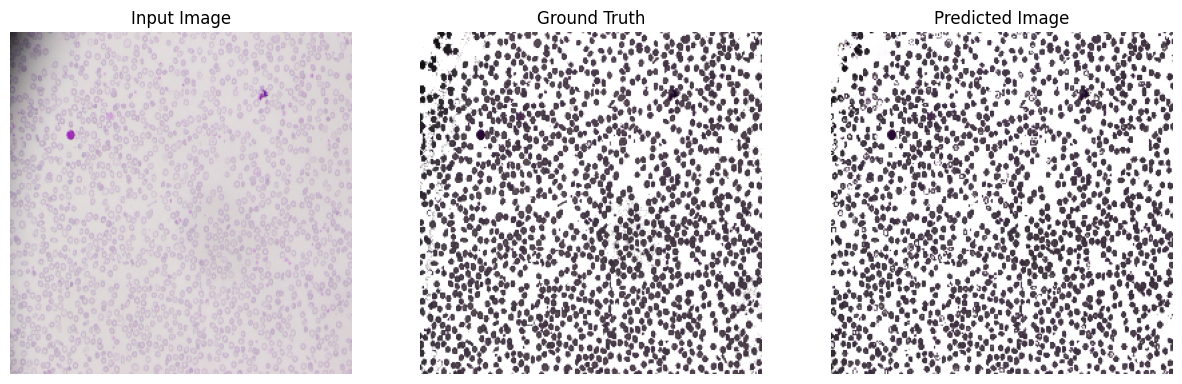

Epoch:  13


2023-10-26 11:40:53.003934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


KeyboardInterrupt: 

In [81]:

history = fit(
    train_dataset, 
    EPOCHS, 
    test_dataset, 
    generator, 
    discriminator, 
    generator_optimizer, 
    discriminator_optimizer, 
    loss_object, 
    accuracy,  # This is the accuracy function you've defined
    generate_images,  # You need to define this function or provide its definition if it's already defined
    checkpoint, 
    checkpoint_prefix
)


In [41]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
#!tensorboard dev upload --logdir  {log_dir}
#!tensorboard dev upload --logdir {log_dir}
!echo "yes" | tensorboard dev upload --logdir {log_dir}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/kaggle/working/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 
To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Go

In [ ]:
display.IFrame(
   src="https://tensorboard.dev/experiment/VY2qtEYZSLO2AiLPmVcMoQ/",
   width="100%",
   height="1000px")

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test dataset
i = 1;
for inp, tar in test_dataset.take(99):
  generate_images(generator, inp, tar,i)
  i=i+1
!zip -r results.zip results